In [1]:
import math
import os
import datetime
import pandas
from pandas import read_csv
from pandas import Series
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import numpy

import keras
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\saulo\AppData\Local\Temp/ipykernel_3480/4274723594.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# converter uma matriz de valores em uma matriz de conjunto de dados
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [3]:
#Criando dicionários para armazenamento de dados
#Dicionários LSMT
dts = dict() #Dicionário de datasets 
trpp = dict() #Dicionário de treinos
tspp = dict() #Dicionário de testes
trs = dict() #Dicionário de scores de treinos 
tss = dict() #Dicionário de scores de testes
tsm = dict() #Dicionário de MAES

#Valores selecionados (Melhores valores)
strpp = dict() #Dicionário de treinos
stspp = dict() #Dicionário de testes
strs = dict() #Dicionário de scores de treinos 
stss = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de scores de testes
stsm = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de MAE's Saída

#Dicionários MLP
dtsMLP = dict() #Dicionário de datasets 
trppMLP = dict() #Dicionário de treinos
tsppMLP = dict() #Dicionário de testes
trsMLP = dict() #Dicionário de scores de treinos 
tssMLP = dict() #Dicionário de scores de testes
t_aMLP = dict() #Dicionário de taxa de aprendizagem
tsmMLP = dict() #Dicionário de MAES

#Valores selecionados (Melhores valores)
strppMLP = dict() #Dicionário de treinos
stsppMLP = dict() #Dicionário de testes
strsMLP = dict() #Dicionário de scores de treinos 
stssMLP = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de scores de testes
stsmMLP = {'Brasil':(9**15), 'Índia':(9**15), 'EUA':(9**15),'Itália':(9**15)} #Dicionário de MAE's Saída

st_aMLP = dict() #Dicionário de taxa de aprendizagem saída

#Ajustes para seleção LSTM
t_a = dict() #Dicionário de taxa de aprendizagem
dropout = dict() #Dicionário de dropout
n_cel = dict() #Dicionário de número de células
st_a = dict() #Dicionário de taxa de aprendizagem saída
sdropout = dict() #Dicionário de dropout saída
sn_cel = dict() #Dicionário de número de células saída

#Ajustes para seleção MLP
t_a = dict() #Dicionário de taxa de aprendizagem
dropoutMLP = dict() #Dicionário de dropout
n_neu = dict() #Dicionário de número de neurônios
st_aMLP = dict() #Dicionário de taxa de aprendizagem saída
sdropoutMLP = dict() #Dicionário de dropout saída
sn_neu = dict() #Dicionário de número de neurônios

#Armazenando testes para plotagem somente dos testes
testP = dict()
testPMLP = dict()
stestPMLP = dict()
testPred = dict()
testPredMLP = dict()
stestPred = dict()
stestPredMLP = dict()

#Armazenando treinos para plotagem somente dos treinos
trainP = dict()
trainPMLP = dict()
strainPMLP = dict()
trainPred = dict()
trainPredMLP = dict()
strainPred = dict()
strainPredMLP = dict()

In [4]:
country = ['Brasil', 'Índia'] #Lista de países

#Grid Search
T_A = [0.01, 0.05, 0.1, 0.2] #0.01, 0.02, 0,03, 0.06, 0.1, 0.2; 
DROP = [0.01, 0.05, 0.1, 0.2]   #0.05, 0.1, 0.15, 0.2, 0.3, 0.5;
N_C = [400, 600]    #50, 100, 200, 300, 400, 600;
NPC = [8, 16, 64, 128] #Neurônios por camada

#Relizando grade de experimentos
for i in range(len(country)):
    for z in range(len(T_A)):
        for j in range(len(DROP)):
            for k in range(len(N_C)):
                if country[i] == 'Brasil':
                    dataframe = read_csv('datasets/countries/casos_covid19_brazil.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                if country[i] == 'Índia':
                    dataframe = read_csv('datasets/countries/mortes_covid19_brazil.csv', usecols=[1], engine='python')
                    dataset = dataframe.values
                    dataset = dataset.astype('float32')
                
                #MLP
                
                # Normalizar o dataset
                scaler = MinMaxScaler(feature_range=(0, 1))
                dataset = scaler.fit_transform(dataset)
                # dividir em conjuntos de treinamento e teste
                #MLP
                train_size = int(len(dataset) * 0.67)
                test_size = len(dataset) - train_size
                train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
                # remodelar em X = t e Y = t + 1
                look_back = 1
                trainX, trainY = create_dataset(train, look_back)
                testX, testY = create_dataset(test, look_back)
                # remodelar a entrada para ser [amostras, intervalos de tempo, recursos]
                trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
                testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
                model = Sequential()
                model.add(Dense(NPC[i], activation='sigmoid', input_dim = 1))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(NPC[i], activation='tanh'))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(NPC[i], activation='relu'))
                model.add(Dropout(float(DROP[j])))
                model.add(Dense(1))
                adam = keras.optimizers.Adam(learning_rate=float(T_A[z]))
                model.compile(optimizer=adam , loss='mean_squared_error')
                model.fit(trainX, trainY, epochs=200, batch_size = 40)
                #fazer previsões
                trainPredictMLP = model.predict(trainX)
                testPredictMLP = model.predict(testX)
                # inverter previsões
                trainPredictMLP = scaler.inverse_transform(trainPredictMLP)
                trainY = scaler.inverse_transform([trainY])
                testPredictMLP = scaler.inverse_transform(testPredictMLP)
                testY = scaler.inverse_transform([testY])
                # calcular raiz quadrada média do erro
                trainScoreMLP = math.sqrt(mean_squared_error(trainY[0], trainPredictMLP[:,0]))
                print('Train Score MLP: %.2f RMSE' % (trainScoreMLP))
                testScoreMLP = math.sqrt(mean_squared_error(testY[0], testPredictMLP[:,0]))
                print('Test Score MLP: %.2f RMSE' % (testScoreMLP))
                #Calcular o MAE:
                MAEMLP = mean_absolute_error(testY[0], testPredictMLP[:,0])
                # mudar para treinar previsões para traçar
                trainPredictPlotMLP = numpy.empty_like(dataset)
                trainPredictPlotMLP[:, :] = numpy.nan
                trainPredictPlotMLP[look_back:len(trainPredictMLP)+look_back, :] = trainPredictMLP
                # previsões de teste de deslocamento para plotagem
                testPredictPlotMLP = numpy.empty_like(dataset)
                testPredictPlotMLP[:, :] = numpy.nan
                testPredictPlotMLP[len(trainPredictMLP)+(look_back*2)+1:len(dataset)-1, :] = testPredictMLP

                trainP[country[i]] = scaler.inverse_transform(train)
                testP[country[i]] = scaler.inverse_transform(test)    
                #Armazenando as informações em dicionários MLP
                tssMLP[country[i]] = testScoreMLP
                trppMLP[country[i]] = trainPredictPlotMLP
                tsppMLP[country[i]] = testPredictPlotMLP
                trsMLP[country[i]] = trainScoreMLP
                t_aMLP[country[i]] = T_A[z]
                dropoutMLP[country[i]] = DROP[j]
                n_neu[country[i]] = NPC[i]
                tsmMLP[country[i]] = MAEMLP
                trainPredMLP[country[i]] = trainPredictMLP
                testPredMLP[country[i]] = testPredictMLP
                
                if tssMLP[country[i]] < stssMLP[country[i]]: #Condição de verificação dos melhores resultados
                    strppMLP[country[i]] = trainPredictPlotMLP
                    stsppMLP[country[i]] = testPredictPlotMLP
                    strsMLP[country[i]] = trainScoreMLP
                    stssMLP[country[i]] = testScoreMLP
                    st_aMLP[country[i]] = T_A[z]
                    sdropoutMLP[country[i]] = DROP[j]
                    sn_neu[country[i]] = NPC[i]
                    stsmMLP[country[i]] = MAEMLP
                    strainPredMLP[country[i]] = trainPredictMLP
                    stestPredMLP[country[i]] = testPredictMLP

Epoch 1/200
12/12 [==============================] - 0s 748us/step - loss: 0.0531
Epoch 2/200
12/12 [==============================] - 0s 665us/step - loss: 0.0408
Epoch 3/200
12/12 [==============================] - 0s 748us/step - loss: 0.0288
Epoch 4/200
12/12 [==============================] - 0s 787us/step - loss: 0.0179
Epoch 5/200
12/12 [==============================] - 0s 627us/step - loss: 0.0188
Epoch 6/200
12/12 [==============================] - 0s 733us/step - loss: 0.0144
Epoch 7/200
12/12 [==============================] - 0s 748us/step - loss: 0.0120
Epoch 8/200
12/12 [==============================] - 0s 665us/step - loss: 0.0097
Epoch 9/200
12/12 [==============================] - 0s 829us/step - loss: 0.0114
Epoch 10/200
12/12 [==============================] - 0s 746us/step - loss: 0.0078
Epoch 11/200
12/12 [==============================] - 0s 679us/step - loss: 0.0077
Epoch 12/200
12/12 [==============================] - 0s 748us/step - loss: 0.0082
Epoch 13/200


12/12 [==============================] - 0s 582us/step - loss: 6.6793e-04
Epoch 99/200
12/12 [==============================] - 0s 582us/step - loss: 7.1907e-04
Epoch 100/200
12/12 [==============================] - 0s 582us/step - loss: 6.1506e-04
Epoch 101/200
12/12 [==============================] - 0s 529us/step - loss: 3.9366e-04
Epoch 102/200
12/12 [==============================] - 0s 582us/step - loss: 6.3835e-04
Epoch 103/200
12/12 [==============================] - 0s 575us/step - loss: 7.5142e-04
Epoch 104/200
12/12 [==============================] - 0s 647us/step - loss: 8.0510e-04
Epoch 105/200
12/12 [==============================] - 0s 499us/step - loss: 6.1341e-04
Epoch 106/200
12/12 [==============================] - 0s 665us/step - loss: 4.8233e-04
Epoch 107/200
12/12 [==============================] - 0s 596us/step - loss: 5.7077e-04
Epoch 108/200
12/12 [==============================] - 0s 662us/step - loss: 9.6739e-04
Epoch 109/200
12/12 [==========================

12/12 [==============================] - 0s 599us/step - loss: 5.3644e-04
Epoch 192/200
12/12 [==============================] - 0s 582us/step - loss: 4.7622e-04
Epoch 193/200
12/12 [==============================] - 0s 668us/step - loss: 5.2327e-04
Epoch 194/200
12/12 [==============================] - 0s 605us/step - loss: 3.4258e-04
Epoch 195/200
12/12 [==============================] - 0s 582us/step - loss: 6.5739e-04
Epoch 196/200
12/12 [==============================] - 0s 582us/step - loss: 3.7706e-04
Epoch 197/200
12/12 [==============================] - 0s 582us/step - loss: 5.3239e-04
Epoch 198/200
12/12 [==============================] - 0s 582us/step - loss: 6.2564e-04
Epoch 199/200
12/12 [==============================] - 0s 663us/step - loss: 3.4773e-04
Epoch 200/200
12/12 [==============================] - 0s 499us/step - loss: 7.0625e-04
Train Score MLP: 444658.33 RMSE
Test Score MLP: 2803423.64 RMSE
Epoch 1/200
12/12 [==============================] - 0s 831us/step - l

12/12 [==============================] - 0s 997us/step - loss: 0.0024
Epoch 89/200
12/12 [==============================] - 0s 997us/step - loss: 0.0013
Epoch 90/200
12/12 [==============================] - 0s 831us/step - loss: 0.0026
Epoch 91/200
12/12 [==============================] - 0s 914us/step - loss: 0.0020
Epoch 92/200
12/12 [==============================] - 0s 911us/step - loss: 0.0014
Epoch 93/200
12/12 [==============================] - 0s 707us/step - loss: 0.0016
Epoch 94/200
12/12 [==============================] - 0s 831us/step - loss: 0.0013
Epoch 95/200
12/12 [==============================] - 0s 831us/step - loss: 0.0018
Epoch 96/200
12/12 [==============================] - 0s 667us/step - loss: 7.6164e-04
Epoch 97/200
12/12 [==============================] - 0s 914us/step - loss: 0.0015
Epoch 98/200
12/12 [==============================] - 0s 831us/step - loss: 0.0018
Epoch 99/200
12/12 [==============================] - 0s 748us/step - loss: 0.0022
Epoch 100/200

Epoch 183/200
12/12 [==============================] - 0s 594us/step - loss: 6.6262e-04
Epoch 184/200
12/12 [==============================] - 0s 665us/step - loss: 5.5985e-04
Epoch 185/200
12/12 [==============================] - 0s 579us/step - loss: 5.9381e-04
Epoch 186/200
12/12 [==============================] - 0s 665us/step - loss: 4.7987e-04
Epoch 187/200
12/12 [==============================] - 0s 579us/step - loss: 5.6093e-04
Epoch 188/200
12/12 [==============================] - 0s 582us/step - loss: 4.7531e-04
Epoch 189/200
12/12 [==============================] - 0s 499us/step - loss: 5.3717e-04
Epoch 190/200
12/12 [==============================] - 0s 582us/step - loss: 7.5149e-04
Epoch 191/200
12/12 [==============================] - 0s 499us/step - loss: 5.9497e-04
Epoch 192/200
12/12 [==============================] - 0s 577us/step - loss: 5.6619e-04
Epoch 193/200
12/12 [==============================] - 0s 499us/step - loss: 7.2801e-04
Epoch 194/200
12/12 [===========

12/12 [==============================] - 0s 568us/step - loss: 0.0030
Epoch 81/200
12/12 [==============================] - 0s 667us/step - loss: 0.0021
Epoch 82/200
12/12 [==============================] - 0s 499us/step - loss: 0.0024
Epoch 83/200
12/12 [==============================] - 0s 601us/step - loss: 0.0033
Epoch 84/200
12/12 [==============================] - 0s 665us/step - loss: 0.0024
Epoch 85/200
12/12 [==============================] - 0s 578us/step - loss: 0.0026
Epoch 86/200
12/12 [==============================] - 0s 647us/step - loss: 0.0024
Epoch 87/200
12/12 [==============================] - 0s 582us/step - loss: 0.0021
Epoch 88/200
12/12 [==============================] - 0s 702us/step - loss: 0.0028
Epoch 89/200
12/12 [==============================] - 0s 579us/step - loss: 0.0027
Epoch 90/200
12/12 [==============================] - 0s 665us/step - loss: 0.0022
Epoch 91/200
12/12 [==============================] - 0s 582us/step - loss: 0.0024
Epoch 92/200
12/1

Epoch 178/200
12/12 [==============================] - 0s 512us/step - loss: 0.0020
Epoch 179/200
12/12 [==============================] - 0s 665us/step - loss: 0.0029
Epoch 180/200
12/12 [==============================] - 0s 649us/step - loss: 0.0019
Epoch 181/200
12/12 [==============================] - 0s 665us/step - loss: 0.0018
Epoch 182/200
12/12 [==============================] - 0s 582us/step - loss: 0.0018
Epoch 183/200
12/12 [==============================] - 0s 499us/step - loss: 0.0022
Epoch 184/200
12/12 [==============================] - 0s 499us/step - loss: 0.0021
Epoch 185/200
12/12 [==============================] - 0s 582us/step - loss: 0.0013
Epoch 186/200
12/12 [==============================] - 0s 499us/step - loss: 0.0018
Epoch 187/200
12/12 [==============================] - 0s 582us/step - loss: 0.0016
Epoch 188/200
12/12 [==============================] - 0s 582us/step - loss: 0.0020
Epoch 189/200
12/12 [==============================] - 0s 582us/step - loss:

12/12 [==============================] - 0s 665us/step - loss: 0.0018
Epoch 76/200
12/12 [==============================] - 0s 600us/step - loss: 0.0033
Epoch 77/200
12/12 [==============================] - 0s 732us/step - loss: 0.0039
Epoch 78/200
12/12 [==============================] - 0s 641us/step - loss: 0.0028
Epoch 79/200
12/12 [==============================] - 0s 618us/step - loss: 0.0028
Epoch 80/200
12/12 [==============================] - 0s 642us/step - loss: 0.0022
Epoch 81/200
12/12 [==============================] - 0s 582us/step - loss: 0.0025
Epoch 82/200
12/12 [==============================] - 0s 714us/step - loss: 0.0020
Epoch 83/200
12/12 [==============================] - 0s 645us/step - loss: 0.0024
Epoch 84/200
12/12 [==============================] - 0s 662us/step - loss: 0.0028
Epoch 85/200
12/12 [==============================] - 0s 594us/step - loss: 0.0023
Epoch 86/200
12/12 [==============================] - 0s 582us/step - loss: 0.0028
Epoch 87/200
12/1

12/12 [==============================] - 0s 750us/step - loss: 0.0016
Epoch 173/200
12/12 [==============================] - 0s 665us/step - loss: 0.0019
Epoch 174/200
12/12 [==============================] - 0s 704us/step - loss: 0.0016
Epoch 175/200
12/12 [==============================] - 0s 699us/step - loss: 0.0020
Epoch 176/200
12/12 [==============================] - 0s 582us/step - loss: 0.0017
Epoch 177/200
12/12 [==============================] - 0s 582us/step - loss: 0.0016
Epoch 178/200
12/12 [==============================] - 0s 582us/step - loss: 0.0022
Epoch 179/200
12/12 [==============================] - 0s 582us/step - loss: 0.0019
Epoch 180/200
12/12 [==============================] - 0s 582us/step - loss: 0.0018
Epoch 181/200
12/12 [==============================] - 0s 582us/step - loss: 0.0017
Epoch 182/200
12/12 [==============================] - 0s 582us/step - loss: 0.0012
Epoch 183/200
12/12 [==============================] - 0s 581us/step - loss: 0.0016
Epoch 

12/12 [==============================] - 0s 695us/step - loss: 0.0045
Epoch 70/200
12/12 [==============================] - 0s 620us/step - loss: 0.0045
Epoch 71/200
12/12 [==============================] - 0s 667us/step - loss: 0.0044
Epoch 72/200
12/12 [==============================] - 0s 582us/step - loss: 0.0055
Epoch 73/200
12/12 [==============================] - 0s 553us/step - loss: 0.0047
Epoch 74/200
12/12 [==============================] - 0s 674us/step - loss: 0.0049
Epoch 75/200
12/12 [==============================] - 0s 636us/step - loss: 0.0048
Epoch 76/200
12/12 [==============================] - 0s 722us/step - loss: 0.0061
Epoch 77/200
12/12 [==============================] - 0s 599us/step - loss: 0.0056
Epoch 78/200
12/12 [==============================] - 0s 652us/step - loss: 0.0055
Epoch 79/200
12/12 [==============================] - 0s 582us/step - loss: 0.0042
Epoch 80/200
12/12 [==============================] - 0s 610us/step - loss: 0.0036
Epoch 81/200
12/1

12/12 [==============================] - 0s 696us/step - loss: 0.0035
Epoch 168/200
12/12 [==============================] - 0s 809us/step - loss: 0.0038
Epoch 169/200
12/12 [==============================] - 0s 700us/step - loss: 0.0042
Epoch 170/200
12/12 [==============================] - 0s 626us/step - loss: 0.0049
Epoch 171/200
12/12 [==============================] - 0s 582us/step - loss: 0.0040
Epoch 172/200
12/12 [==============================] - 0s 515us/step - loss: 0.0037
Epoch 173/200
12/12 [==============================] - 0s 621us/step - loss: 0.0035
Epoch 174/200
12/12 [==============================] - 0s 582us/step - loss: 0.0044
Epoch 175/200
12/12 [==============================] - 0s 666us/step - loss: 0.0036
Epoch 176/200
12/12 [==============================] - 0s 579us/step - loss: 0.0027
Epoch 177/200
12/12 [==============================] - 0s 665us/step - loss: 0.0056
Epoch 178/200
12/12 [==============================] - 0s 582us/step - loss: 0.0031
Epoch 

12/12 [==============================] - 0s 670us/step - loss: 0.0049
Epoch 65/200
12/12 [==============================] - 0s 665us/step - loss: 0.0044
Epoch 66/200
12/12 [==============================] - 0s 582us/step - loss: 0.0050
Epoch 67/200
12/12 [==============================] - 0s 663us/step - loss: 0.0053
Epoch 68/200
12/12 [==============================] - 0s 582us/step - loss: 0.0048
Epoch 69/200
12/12 [==============================] - 0s 654us/step - loss: 0.0046
Epoch 70/200
12/12 [==============================] - 0s 527us/step - loss: 0.0049
Epoch 71/200
12/12 [==============================] - 0s 582us/step - loss: 0.0052
Epoch 72/200
12/12 [==============================] - 0s 583us/step - loss: 0.0050
Epoch 73/200
12/12 [==============================] - 0s 582us/step - loss: 0.0046
Epoch 74/200
12/12 [==============================] - 0s 499us/step - loss: 0.0052
Epoch 75/200
12/12 [==============================] - 0s 582us/step - loss: 0.0051
Epoch 76/200
12/1

12/12 [==============================] - 0s 582us/step - loss: 0.0029
Epoch 163/200
12/12 [==============================] - 0s 663us/step - loss: 0.0035
Epoch 164/200
12/12 [==============================] - 0s 572us/step - loss: 0.0027
Epoch 165/200
12/12 [==============================] - 0s 662us/step - loss: 0.0043
Epoch 166/200
12/12 [==============================] - 0s 509us/step - loss: 0.0035
Epoch 167/200
12/12 [==============================] - 0s 660us/step - loss: 0.0041
Epoch 168/200
12/12 [==============================] - 0s 582us/step - loss: 0.0031
Epoch 169/200
12/12 [==============================] - 0s 582us/step - loss: 0.0036
Epoch 170/200
12/12 [==============================] - 0s 582us/step - loss: 0.0030
Epoch 171/200
12/12 [==============================] - 0s 582us/step - loss: 0.0045
Epoch 172/200
12/12 [==============================] - 0s 499us/step - loss: 0.0035
Epoch 173/200
12/12 [==============================] - 0s 582us/step - loss: 0.0036
Epoch 

12/12 [==============================] - 0s 686us/step - loss: 0.0112
Epoch 60/200
12/12 [==============================] - 0s 582us/step - loss: 0.0137
Epoch 61/200
12/12 [==============================] - 0s 665us/step - loss: 0.0128
Epoch 62/200
12/12 [==============================] - 0s 665us/step - loss: 0.0130
Epoch 63/200
12/12 [==============================] - 0s 499us/step - loss: 0.0119
Epoch 64/200
12/12 [==============================] - 0s 582us/step - loss: 0.0104
Epoch 65/200
12/12 [==============================] - 0s 582us/step - loss: 0.0110
Epoch 66/200
12/12 [==============================] - 0s 582us/step - loss: 0.0108
Epoch 67/200
12/12 [==============================] - 0s 582us/step - loss: 0.0127
Epoch 68/200
12/12 [==============================] - 0s 582us/step - loss: 0.0119
Epoch 69/200
12/12 [==============================] - 0s 499us/step - loss: 0.0113
Epoch 70/200
12/12 [==============================] - 0s 582us/step - loss: 0.0114
Epoch 71/200
12/1

12/12 [==============================] - 0s 582us/step - loss: 0.0087
Epoch 158/200
12/12 [==============================] - 0s 665us/step - loss: 0.0117
Epoch 159/200
12/12 [==============================] - 0s 612us/step - loss: 0.0101
Epoch 160/200
12/12 [==============================] - 0s 665us/step - loss: 0.0093
Epoch 161/200
12/12 [==============================] - 0s 576us/step - loss: 0.0095
Epoch 162/200
12/12 [==============================] - 0s 582us/step - loss: 0.0099
Epoch 163/200
12/12 [==============================] - 0s 517us/step - loss: 0.0085
Epoch 164/200
12/12 [==============================] - 0s 623us/step - loss: 0.0109
Epoch 165/200
12/12 [==============================] - 0s 582us/step - loss: 0.0088
Epoch 166/200
12/12 [==============================] - 0s 662us/step - loss: 0.0102
Epoch 167/200
12/12 [==============================] - 0s 663us/step - loss: 0.0114
Epoch 168/200
12/12 [==============================] - 0s 582us/step - loss: 0.0112
Epoch 

12/12 [==============================] - 0s 665us/step - loss: 0.0098
Epoch 55/200
12/12 [==============================] - 0s 621us/step - loss: 0.0102
Epoch 56/200
12/12 [==============================] - 0s 662us/step - loss: 0.0115
Epoch 57/200
12/12 [==============================] - 0s 499us/step - loss: 0.0101
Epoch 58/200
12/12 [==============================] - 0s 582us/step - loss: 0.0098
Epoch 59/200
12/12 [==============================] - 0s 529us/step - loss: 0.0103
Epoch 60/200
12/12 [==============================] - 0s 665us/step - loss: 0.0086
Epoch 61/200
12/12 [==============================] - 0s 582us/step - loss: 0.0105
Epoch 62/200
12/12 [==============================] - 0s 588us/step - loss: 0.0100
Epoch 63/200
12/12 [==============================] - 0s 499us/step - loss: 0.0101
Epoch 64/200
12/12 [==============================] - 0s 665us/step - loss: 0.0097
Epoch 65/200
12/12 [==============================] - 0s 645us/step - loss: 0.0097
Epoch 66/200
12/1

12/12 [==============================] - 0s 580us/step - loss: 0.0078
Epoch 153/200
12/12 [==============================] - 0s 582us/step - loss: 0.0092
Epoch 154/200
12/12 [==============================] - 0s 582us/step - loss: 0.0084
Epoch 155/200
12/12 [==============================] - 0s 748us/step - loss: 0.0081
Epoch 156/200
12/12 [==============================] - 0s 625us/step - loss: 0.0064
Epoch 157/200
12/12 [==============================] - 0s 531us/step - loss: 0.0065
Epoch 158/200
12/12 [==============================] - 0s 582us/step - loss: 0.0070
Epoch 159/200
12/12 [==============================] - 0s 499us/step - loss: 0.0096
Epoch 160/200
12/12 [==============================] - 0s 582us/step - loss: 0.0093
Epoch 161/200
12/12 [==============================] - 0s 499us/step - loss: 0.0076
Epoch 162/200
12/12 [==============================] - 0s 582us/step - loss: 0.0066
Epoch 163/200
12/12 [==============================] - 0s 499us/step - loss: 0.0068
Epoch 

12/12 [==============================] - 0s 582us/step - loss: 0.0019
Epoch 50/200
12/12 [==============================] - 0s 639us/step - loss: 0.0023
Epoch 51/200
12/12 [==============================] - 0s 665us/step - loss: 0.0018
Epoch 52/200
12/12 [==============================] - 0s 599us/step - loss: 0.0018
Epoch 53/200
12/12 [==============================] - 0s 775us/step - loss: 0.0022
Epoch 54/200
12/12 [==============================] - 0s 544us/step - loss: 0.0016
Epoch 55/200
12/12 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 56/200
12/12 [==============================] - 0s 572us/step - loss: 0.0023
Epoch 57/200
12/12 [==============================] - 0s 652us/step - loss: 0.0019
Epoch 58/200
12/12 [==============================] - 0s 582us/step - loss: 0.0019
Epoch 59/200
12/12 [==============================] - 0s 606us/step - loss: 0.0013
Epoch 60/200
12/12 [==============================] - 0s 582us/step - loss: 0.0018
Epoch 61/200
12/12 

12/12 [==============================] - 0s 499us/step - loss: 6.5674e-04
Epoch 147/200
12/12 [==============================] - 0s 582us/step - loss: 7.2640e-04
Epoch 148/200
12/12 [==============================] - 0s 582us/step - loss: 7.3475e-04
Epoch 149/200
12/12 [==============================] - 0s 685us/step - loss: 0.0010
Epoch 150/200
12/12 [==============================] - 0s 665us/step - loss: 0.0016
Epoch 151/200
12/12 [==============================] - 0s 657us/step - loss: 9.1998e-04
Epoch 152/200
12/12 [==============================] - 0s 582us/step - loss: 6.5011e-04
Epoch 153/200
12/12 [==============================] - 0s 665us/step - loss: 8.6246e-04
Epoch 154/200
12/12 [==============================] - 0s 514us/step - loss: 0.0019
Epoch 155/200
12/12 [==============================] - 0s 665us/step - loss: 9.8732e-04
Epoch 156/200
12/12 [==============================] - 0s 649us/step - loss: 9.0118e-04
Epoch 157/200
12/12 [==============================] - 0s 

12/12 [==============================] - 0s 665us/step - loss: 0.0023
Epoch 42/200
12/12 [==============================] - 0s 665us/step - loss: 0.0046
Epoch 43/200
12/12 [==============================] - 0s 748us/step - loss: 0.0024
Epoch 44/200
12/12 [==============================] - 0s 751us/step - loss: 0.0019
Epoch 45/200
12/12 [==============================] - 0s 745us/step - loss: 0.0011
Epoch 46/200
12/12 [==============================] - 0s 748us/step - loss: 0.0013
Epoch 47/200
12/12 [==============================] - 0s 665us/step - loss: 0.0014
Epoch 48/200
12/12 [==============================] - 0s 697us/step - loss: 0.0027
Epoch 49/200
12/12 [==============================] - 0s 746us/step - loss: 0.0016
Epoch 50/200
12/12 [==============================] - 0s 748us/step - loss: 0.0027
Epoch 51/200
12/12 [==============================] - 0s 914us/step - loss: 0.0018
Epoch 52/200
12/12 [==============================] - 0s 831us/step - loss: 0.0025
Epoch 53/200
12/1

12/12 [==============================] - 0s 748us/step - loss: 0.0020
Epoch 139/200
12/12 [==============================] - 0s 665us/step - loss: 0.0025
Epoch 140/200
12/12 [==============================] - 0s 748us/step - loss: 0.0027
Epoch 141/200
12/12 [==============================] - 0s 840us/step - loss: 6.9465e-04
Epoch 142/200
12/12 [==============================] - 0s 831us/step - loss: 0.0015
Epoch 143/200
12/12 [==============================] - 0s 762us/step - loss: 0.0018
Epoch 144/200
12/12 [==============================] - 0s 802us/step - loss: 8.9903e-04
Epoch 145/200
12/12 [==============================] - 0s 799us/step - loss: 0.0016
Epoch 146/200
12/12 [==============================] - 0s 706us/step - loss: 8.1052e-04
Epoch 147/200
12/12 [==============================] - 0s 750us/step - loss: 0.0015
Epoch 148/200
12/12 [==============================] - 0s 748us/step - loss: 7.3243e-04
Epoch 149/200
12/12 [==============================] - 0s 693us/step - los

12/12 [==============================] - 0s 665us/step - loss: 0.0473
Epoch 35/200
12/12 [==============================] - 0s 680us/step - loss: 0.0464
Epoch 36/200
12/12 [==============================] - 0s 746us/step - loss: 0.0470
Epoch 37/200
12/12 [==============================] - 0s 665us/step - loss: 0.0454
Epoch 38/200
12/12 [==============================] - 0s 709us/step - loss: 0.0456
Epoch 39/200
12/12 [==============================] - 0s 665us/step - loss: 0.0461
Epoch 40/200
12/12 [==============================] - 0s 663us/step - loss: 0.0460
Epoch 41/200
12/12 [==============================] - 0s 827us/step - loss: 0.0456
Epoch 42/200
12/12 [==============================] - 0s 722us/step - loss: 0.0472
Epoch 43/200
12/12 [==============================] - 0s 665us/step - loss: 0.0462
Epoch 44/200
12/12 [==============================] - 0s 818us/step - loss: 0.0463
Epoch 45/200
12/12 [==============================] - 0s 667us/step - loss: 0.0469
Epoch 46/200
12/1

12/12 [==============================] - 0s 831us/step - loss: 0.0481
Epoch 133/200
12/12 [==============================] - 0s 768us/step - loss: 0.0458
Epoch 134/200
12/12 [==============================] - 0s 814us/step - loss: 0.0465
Epoch 135/200
12/12 [==============================] - 0s 758us/step - loss: 0.0458
Epoch 136/200
12/12 [==============================] - 0s 665us/step - loss: 0.0456
Epoch 137/200
12/12 [==============================] - 0s 821us/step - loss: 0.0459
Epoch 138/200
12/12 [==============================] - 0s 833us/step - loss: 0.0466
Epoch 139/200
12/12 [==============================] - 0s 745us/step - loss: 0.0455
Epoch 140/200
12/12 [==============================] - 0s 847us/step - loss: 0.0463
Epoch 141/200
12/12 [==============================] - 0s 855us/step - loss: 0.0465
Epoch 142/200
12/12 [==============================] - 0s 646us/step - loss: 0.0458
Epoch 143/200
12/12 [==============================] - 0s 750us/step - loss: 0.0458
Epoch 

12/12 [==============================] - 0s 747us/step - loss: 0.0036
Epoch 30/200
12/12 [==============================] - 0s 750us/step - loss: 0.0036
Epoch 31/200
12/12 [==============================] - 0s 729us/step - loss: 0.0035
Epoch 32/200
12/12 [==============================] - 0s 831us/step - loss: 0.0025
Epoch 33/200
12/12 [==============================] - 0s 665us/step - loss: 0.0034
Epoch 34/200
12/12 [==============================] - 0s 772us/step - loss: 0.0036
Epoch 35/200
12/12 [==============================] - 0s 662us/step - loss: 0.0029
Epoch 36/200
12/12 [==============================] - 0s 683us/step - loss: 0.0037
Epoch 37/200
12/12 [==============================] - 0s 783us/step - loss: 0.0023
Epoch 38/200
12/12 [==============================] - 0s 665us/step - loss: 0.0022
Epoch 39/200
12/12 [==============================] - 0s 665us/step - loss: 0.0020
Epoch 40/200
12/12 [==============================] - 0s 878us/step - loss: 0.0019
Epoch 41/200
12/1

12/12 [==============================] - 0s 748us/step - loss: 0.0017
Epoch 128/200
12/12 [==============================] - 0s 786us/step - loss: 0.0014
Epoch 129/200
12/12 [==============================] - 0s 775us/step - loss: 0.0022
Epoch 130/200
12/12 [==============================] - 0s 746us/step - loss: 0.0019
Epoch 131/200
12/12 [==============================] - 0s 748us/step - loss: 0.0025
Epoch 132/200
12/12 [==============================] - 0s 807us/step - loss: 0.0022
Epoch 133/200
12/12 [==============================] - 0s 830us/step - loss: 0.0104
Epoch 134/200
12/12 [==============================] - 0s 665us/step - loss: 0.0053
Epoch 135/200
12/12 [==============================] - 0s 691us/step - loss: 0.0036
Epoch 136/200
12/12 [==============================] - 0s 912us/step - loss: 0.0032
Epoch 137/200
12/12 [==============================] - 0s 749us/step - loss: 0.0038
Epoch 138/200
12/12 [==============================] - 0s 780us/step - loss: 0.0031
Epoch 

12/12 [==============================] - 0s 665us/step - loss: 0.0210
Epoch 25/200
12/12 [==============================] - 0s 692us/step - loss: 0.0151
Epoch 26/200
12/12 [==============================] - 0s 748us/step - loss: 0.0164
Epoch 27/200
12/12 [==============================] - 0s 751us/step - loss: 0.0144
Epoch 28/200
12/12 [==============================] - 0s 663us/step - loss: 0.0119
Epoch 29/200
12/12 [==============================] - 0s 739us/step - loss: 0.0133
Epoch 30/200
12/12 [==============================] - 0s 582us/step - loss: 0.0094
Epoch 31/200
12/12 [==============================] - 0s 648us/step - loss: 0.0117
Epoch 32/200
12/12 [==============================] - 0s 831us/step - loss: 0.0087
Epoch 33/200
12/12 [==============================] - 0s 597us/step - loss: 0.0096
Epoch 34/200
12/12 [==============================] - 0s 774us/step - loss: 0.0083
Epoch 35/200
12/12 [==============================] - 0s 868us/step - loss: 0.0078
Epoch 36/200
12/1

12/12 [==============================] - 0s 831us/step - loss: 0.0035
Epoch 123/200
12/12 [==============================] - 0s 833us/step - loss: 0.0038
Epoch 124/200
12/12 [==============================] - 0s 829us/step - loss: 0.0036
Epoch 125/200
12/12 [==============================] - 0s 709us/step - loss: 0.0035
Epoch 126/200
12/12 [==============================] - 0s 793us/step - loss: 0.0034
Epoch 127/200
12/12 [==============================] - 0s 874us/step - loss: 0.0037
Epoch 128/200
12/12 [==============================] - 0s 831us/step - loss: 0.0034
Epoch 129/200
12/12 [==============================] - 0s 797us/step - loss: 0.0035
Epoch 130/200
12/12 [==============================] - 0s 721us/step - loss: 0.0040
Epoch 131/200
12/12 [==============================] - 0s 827us/step - loss: 0.0032
Epoch 132/200
12/12 [==============================] - 0s 748us/step - loss: 0.0036
Epoch 133/200
12/12 [==============================] - 0s 758us/step - loss: 0.0033
Epoch 

12/12 [==============================] - 0s 668us/step - loss: 0.0457
Epoch 20/200
12/12 [==============================] - 0s 748us/step - loss: 0.0434
Epoch 21/200
12/12 [==============================] - 0s 748us/step - loss: 0.0350
Epoch 22/200
12/12 [==============================] - 0s 677us/step - loss: 0.0272
Epoch 23/200
12/12 [==============================] - 0s 714us/step - loss: 0.0241
Epoch 24/200
12/12 [==============================] - 0s 673us/step - loss: 0.0180
Epoch 25/200
12/12 [==============================] - 0s 846us/step - loss: 0.0172
Epoch 26/200
12/12 [==============================] - 0s 837us/step - loss: 0.0196
Epoch 27/200
12/12 [==============================] - 0s 661us/step - loss: 0.0151
Epoch 28/200
12/12 [==============================] - 0s 880us/step - loss: 0.0183
Epoch 29/200
12/12 [==============================] - 0s 797us/step - loss: 0.0180
Epoch 30/200
12/12 [==============================] - 0s 673us/step - loss: 0.0178
Epoch 31/200
12/1

12/12 [==============================] - 0s 910us/step - loss: 0.0081
Epoch 118/200
12/12 [==============================] - 0s 912us/step - loss: 0.0073
Epoch 119/200
12/12 [==============================] - 0s 831us/step - loss: 0.0054
Epoch 120/200
12/12 [==============================] - 0s 824us/step - loss: 0.0088
Epoch 121/200
12/12 [==============================] - 0s 822us/step - loss: 0.0059
Epoch 122/200
12/12 [==============================] - 0s 855us/step - loss: 0.0080
Epoch 123/200
12/12 [==============================] - 0s 759us/step - loss: 0.0052
Epoch 124/200
12/12 [==============================] - 0s 784us/step - loss: 0.0052
Epoch 125/200
12/12 [==============================] - 0s 875us/step - loss: 0.0053
Epoch 126/200
12/12 [==============================] - 0s 829us/step - loss: 0.0058
Epoch 127/200
12/12 [==============================] - 0s 817us/step - loss: 0.0077
Epoch 128/200
12/12 [==============================] - 0s 793us/step - loss: 0.0057
Epoch 

12/12 [==============================] - 0s 663us/step - loss: 0.0139
Epoch 15/200
12/12 [==============================] - 0s 579us/step - loss: 0.0133
Epoch 16/200
12/12 [==============================] - 0s 748us/step - loss: 0.0117
Epoch 17/200
12/12 [==============================] - 0s 582us/step - loss: 0.0117
Epoch 18/200
12/12 [==============================] - 0s 582us/step - loss: 0.0099
Epoch 19/200
12/12 [==============================] - 0s 665us/step - loss: 0.0112
Epoch 20/200
12/12 [==============================] - 0s 526us/step - loss: 0.0111
Epoch 21/200
12/12 [==============================] - 0s 668us/step - loss: 0.0093
Epoch 22/200
12/12 [==============================] - 0s 651us/step - loss: 0.0117
Epoch 23/200
12/12 [==============================] - 0s 665us/step - loss: 0.0106
Epoch 24/200
12/12 [==============================] - 0s 659us/step - loss: 0.0093
Epoch 25/200
12/12 [==============================] - 0s 654us/step - loss: 0.0108
Epoch 26/200
12/1

12/12 [==============================] - 0s 787us/step - loss: 0.0069
Epoch 113/200
12/12 [==============================] - 0s 833us/step - loss: 0.0068
Epoch 114/200
12/12 [==============================] - 0s 831us/step - loss: 0.0070
Epoch 115/200
12/12 [==============================] - 0s 665us/step - loss: 0.0072
Epoch 116/200
12/12 [==============================] - 0s 735us/step - loss: 0.0069
Epoch 117/200
12/12 [==============================] - 0s 847us/step - loss: 0.0073
Epoch 118/200
12/12 [==============================] - 0s 663us/step - loss: 0.0099
Epoch 119/200
12/12 [==============================] - 0s 662us/step - loss: 0.0089
Epoch 120/200
12/12 [==============================] - 0s 748us/step - loss: 0.0075
Epoch 121/200
12/12 [==============================] - 0s 713us/step - loss: 0.0085
Epoch 122/200
12/12 [==============================] - 0s 849us/step - loss: 0.0091
Epoch 123/200
12/12 [==============================] - 0s 748us/step - loss: 0.0092
Epoch 

12/12 [==============================] - 0s 745us/step - loss: 0.0259
Epoch 10/200
12/12 [==============================] - 0s 603us/step - loss: 0.0237
Epoch 11/200
12/12 [==============================] - 0s 708us/step - loss: 0.0243
Epoch 12/200
12/12 [==============================] - 0s 746us/step - loss: 0.0216
Epoch 13/200
12/12 [==============================] - 0s 582us/step - loss: 0.0229
Epoch 14/200
12/12 [==============================] - 0s 771us/step - loss: 0.0207
Epoch 15/200
12/12 [==============================] - 0s 584us/step - loss: 0.0202
Epoch 16/200
12/12 [==============================] - 0s 550us/step - loss: 0.0156
Epoch 17/200
12/12 [==============================] - 0s 665us/step - loss: 0.0125
Epoch 18/200
12/12 [==============================] - 0s 582us/step - loss: 0.0163
Epoch 19/200
12/12 [==============================] - 0s 748us/step - loss: 0.0162
Epoch 20/200
12/12 [==============================] - 0s 601us/step - loss: 0.0155
Epoch 21/200
12/1

12/12 [==============================] - 0s 820us/step - loss: 0.0089
Epoch 108/200
12/12 [==============================] - 0s 831us/step - loss: 0.0098
Epoch 109/200
12/12 [==============================] - 0s 748us/step - loss: 0.0079
Epoch 110/200
12/12 [==============================] - 0s 831us/step - loss: 0.0096
Epoch 111/200
12/12 [==============================] - 0s 882us/step - loss: 0.0069
Epoch 112/200
12/12 [==============================] - 0s 695us/step - loss: 0.0074
Epoch 113/200
12/12 [==============================] - 0s 743us/step - loss: 0.0080
Epoch 114/200
12/12 [==============================] - 0s 873us/step - loss: 0.0079
Epoch 115/200
12/12 [==============================] - 0s 665us/step - loss: 0.0067
Epoch 116/200
12/12 [==============================] - 0s 786us/step - loss: 0.0067
Epoch 117/200
12/12 [==============================] - 0s 830us/step - loss: 0.0086
Epoch 118/200
12/12 [==============================] - 0s 831us/step - loss: 0.0090
Epoch 

12/12 [==============================] - 0s 751us/step - loss: 0.1196
Epoch 2/200
12/12 [==============================] - 0s 582us/step - loss: 0.0563
Epoch 3/200
12/12 [==============================] - 0s 579us/step - loss: 0.0370
Epoch 4/200
12/12 [==============================] - 0s 661us/step - loss: 0.0217
Epoch 5/200
12/12 [==============================] - 0s 665us/step - loss: 0.0049
Epoch 6/200
12/12 [==============================] - 0s 579us/step - loss: 0.0048
Epoch 7/200
12/12 [==============================] - 0s 665us/step - loss: 0.0026
Epoch 8/200
12/12 [==============================] - 0s 580us/step - loss: 0.0027
Epoch 9/200
12/12 [==============================] - 0s 602us/step - loss: 0.0024
Epoch 10/200
12/12 [==============================] - 0s 582us/step - loss: 0.0021
Epoch 11/200
12/12 [==============================] - 0s 680us/step - loss: 0.0026
Epoch 12/200
12/12 [==============================] - 0s 584us/step - loss: 0.0019
Epoch 13/200
12/12 [=====

12/12 [==============================] - 0s 762us/step - loss: 0.0013
Epoch 100/200
12/12 [==============================] - 0s 816us/step - loss: 0.0012
Epoch 101/200
12/12 [==============================] - 0s 831us/step - loss: 0.0025
Epoch 102/200
12/12 [==============================] - 0s 780us/step - loss: 3.5491e-04
Epoch 103/200
12/12 [==============================] - 0s 748us/step - loss: 4.0637e-04
Epoch 104/200
12/12 [==============================] - 0s 748us/step - loss: 0.0012
Epoch 105/200
12/12 [==============================] - 0s 740us/step - loss: 0.0013
Epoch 106/200
12/12 [==============================] - 0s 665us/step - loss: 0.0015
Epoch 107/200
12/12 [==============================] - 0s 748us/step - loss: 8.8990e-04
Epoch 108/200
12/12 [==============================] - 0s 726us/step - loss: 7.6662e-04
Epoch 109/200
12/12 [==============================] - 0s 786us/step - loss: 0.0012
Epoch 110/200
12/12 [==============================] - 0s 748us/step - los

12/12 [==============================] - 0s 792us/step - loss: 0.0461
Epoch 195/200
12/12 [==============================] - 0s 809us/step - loss: 0.0465
Epoch 196/200
12/12 [==============================] - 0s 750us/step - loss: 0.0498
Epoch 197/200
12/12 [==============================] - 0s 885us/step - loss: 0.0477
Epoch 198/200
12/12 [==============================] - 0s 744us/step - loss: 0.0463
Epoch 199/200
12/12 [==============================] - 0s 877us/step - loss: 0.0476
Epoch 200/200
12/12 [==============================] - 0s 748us/step - loss: 0.0462
Train Score MLP: 4777532.50 RMSE
Test Score MLP: 14407285.45 RMSE
Epoch 1/200
12/12 [==============================] - 0s 718us/step - loss: 0.1666
Epoch 2/200
12/12 [==============================] - 0s 593us/step - loss: 0.0464
Epoch 3/200
12/12 [==============================] - 0s 664us/step - loss: 0.0459
Epoch 4/200
12/12 [==============================] - 0s 591us/step - loss: 0.0478
Epoch 5/200
12/12 [=============

12/12 [==============================] - 0s 829us/step - loss: 0.0021
Epoch 93/200
12/12 [==============================] - 0s 740us/step - loss: 0.0030
Epoch 94/200
12/12 [==============================] - 0s 649us/step - loss: 0.0018
Epoch 95/200
12/12 [==============================] - 0s 818us/step - loss: 0.0030
Epoch 96/200
12/12 [==============================] - 0s 683us/step - loss: 0.0011
Epoch 97/200
12/12 [==============================] - 0s 665us/step - loss: 0.0032
Epoch 98/200
12/12 [==============================] - 0s 821us/step - loss: 0.0017
Epoch 99/200
12/12 [==============================] - 0s 667us/step - loss: 0.0033
Epoch 100/200
12/12 [==============================] - 0s 665us/step - loss: 0.0027
Epoch 101/200
12/12 [==============================] - 0s 831us/step - loss: 0.0014
Epoch 102/200
12/12 [==============================] - 0s 748us/step - loss: 0.0031
Epoch 103/200
12/12 [==============================] - 0s 665us/step - loss: 0.0052
Epoch 104/200

12/12 [==============================] - 0s 746us/step - loss: 0.0018
Epoch 190/200
12/12 [==============================] - 0s 889us/step - loss: 0.0013
Epoch 191/200
12/12 [==============================] - 0s 914us/step - loss: 0.0011
Epoch 192/200
12/12 [==============================] - 0s 748us/step - loss: 9.1090e-04
Epoch 193/200
12/12 [==============================] - 0s 665us/step - loss: 9.8860e-04
Epoch 194/200
12/12 [==============================] - 0s 831us/step - loss: 0.0016
Epoch 195/200
12/12 [==============================] - 0s 864us/step - loss: 0.0012
Epoch 196/200
12/12 [==============================] - 0s 726us/step - loss: 6.4003e-04
Epoch 197/200
12/12 [==============================] - 0s 746us/step - loss: 0.0016
Epoch 198/200
12/12 [==============================] - 0s 748us/step - loss: 0.0011
Epoch 199/200
12/12 [==============================] - 0s 705us/step - loss: 0.0010
Epoch 200/200
12/12 [==============================] - 0s 748us/step - loss: 0

Epoch 87/200
12/12 [==============================] - 0s 833us/step - loss: 0.0044
Epoch 88/200
12/12 [==============================] - 0s 831us/step - loss: 0.0052
Epoch 89/200
12/12 [==============================] - 0s 833us/step - loss: 0.0049
Epoch 90/200
12/12 [==============================] - 0s 670us/step - loss: 0.0036
Epoch 91/200
12/12 [==============================] - 0s 709us/step - loss: 0.0040
Epoch 92/200
12/12 [==============================] - 0s 830us/step - loss: 0.0040
Epoch 93/200
12/12 [==============================] - 0s 746us/step - loss: 0.0035
Epoch 94/200
12/12 [==============================] - 0s 684us/step - loss: 0.0048
Epoch 95/200
12/12 [==============================] - 0s 748us/step - loss: 0.0054
Epoch 96/200
12/12 [==============================] - 0s 746us/step - loss: 0.0029
Epoch 97/200
12/12 [==============================] - 0s 767us/step - loss: 0.0037
Epoch 98/200
12/12 [==============================] - 0s 945us/step - loss: 0.0052
Epoc

12/12 [==============================] - 0s 845us/step - loss: 0.0067
Epoch 185/200
12/12 [==============================] - 0s 745us/step - loss: 0.0041
Epoch 186/200
12/12 [==============================] - 0s 665us/step - loss: 0.0047
Epoch 187/200
12/12 [==============================] - 0s 746us/step - loss: 0.0041
Epoch 188/200
12/12 [==============================] - 0s 746us/step - loss: 0.0046
Epoch 189/200
12/12 [==============================] - 0s 748us/step - loss: 0.0040
Epoch 190/200
12/12 [==============================] - 0s 667us/step - loss: 0.0077
Epoch 191/200
12/12 [==============================] - 0s 766us/step - loss: 0.0064
Epoch 192/200
12/12 [==============================] - 0s 700us/step - loss: 0.0048
Epoch 193/200
12/12 [==============================] - 0s 702us/step - loss: 0.0039
Epoch 194/200
12/12 [==============================] - 0s 668us/step - loss: 0.0036
Epoch 195/200
12/12 [==============================] - 0s 861us/step - loss: 0.0024
Epoch 

12/12 [==============================] - 0s 690us/step - loss: 0.0487
Epoch 83/200
12/12 [==============================] - 0s 774us/step - loss: 0.0463
Epoch 84/200
12/12 [==============================] - 0s 748us/step - loss: 0.0462
Epoch 85/200
12/12 [==============================] - 0s 757us/step - loss: 0.0465
Epoch 86/200
12/12 [==============================] - 0s 806us/step - loss: 0.0459
Epoch 87/200
12/12 [==============================] - 0s 748us/step - loss: 0.0456
Epoch 88/200
12/12 [==============================] - 0s 748us/step - loss: 0.0457
Epoch 89/200
12/12 [==============================] - 0s 778us/step - loss: 0.0470
Epoch 90/200
12/12 [==============================] - 0s 748us/step - loss: 0.0452
Epoch 91/200
12/12 [==============================] - 0s 682us/step - loss: 0.0481
Epoch 92/200
12/12 [==============================] - 0s 726us/step - loss: 0.0479
Epoch 93/200
12/12 [==============================] - 0s 745us/step - loss: 0.0465
Epoch 94/200
12/1

12/12 [==============================] - 0s 740us/step - loss: 0.0464
Epoch 180/200
12/12 [==============================] - 0s 743us/step - loss: 0.0457
Epoch 181/200
12/12 [==============================] - 0s 912us/step - loss: 0.0458
Epoch 182/200
12/12 [==============================] - 0s 831us/step - loss: 0.0464
Epoch 183/200
12/12 [==============================] - 0s 732us/step - loss: 0.0471
Epoch 184/200
12/12 [==============================] - 0s 748us/step - loss: 0.0463
Epoch 185/200
12/12 [==============================] - 0s 831us/step - loss: 0.0460
Epoch 186/200
12/12 [==============================] - 0s 697us/step - loss: 0.0466
Epoch 187/200
12/12 [==============================] - 0s 692us/step - loss: 0.0467
Epoch 188/200
12/12 [==============================] - 0s 746us/step - loss: 0.0458
Epoch 189/200
12/12 [==============================] - 0s 665us/step - loss: 0.0461
Epoch 190/200
12/12 [==============================] - 0s 774us/step - loss: 0.0469
Epoch 

Epoch 77/200
12/12 [==============================] - 0s 819us/step - loss: 0.0477
Epoch 78/200
12/12 [==============================] - 0s 829us/step - loss: 0.0454
Epoch 79/200
12/12 [==============================] - 0s 732us/step - loss: 0.0457
Epoch 80/200
12/12 [==============================] - 0s 833us/step - loss: 0.0474
Epoch 81/200
12/12 [==============================] - 0s 849us/step - loss: 0.0463
Epoch 82/200
12/12 [==============================] - 0s 748us/step - loss: 0.0456
Epoch 83/200
12/12 [==============================] - 0s 748us/step - loss: 0.0457
Epoch 84/200
12/12 [==============================] - 0s 748us/step - loss: 0.0455
Epoch 85/200
12/12 [==============================] - 0s 750us/step - loss: 0.0453
Epoch 86/200
12/12 [==============================] - 0s 748us/step - loss: 0.0474
Epoch 87/200
12/12 [==============================] - 0s 879us/step - loss: 0.0461
Epoch 88/200
12/12 [==============================] - 0s 665us/step - loss: 0.0465
Epoc

12/12 [==============================] - 0s 695us/step - loss: 0.0470
Epoch 175/200
12/12 [==============================] - 0s 748us/step - loss: 0.0458
Epoch 176/200
12/12 [==============================] - 0s 831us/step - loss: 0.0483
Epoch 177/200
12/12 [==============================] - 0s 832us/step - loss: 0.0470
Epoch 178/200
12/12 [==============================] - 0s 713us/step - loss: 0.0459
Epoch 179/200
12/12 [==============================] - 0s 751us/step - loss: 0.0466
Epoch 180/200
12/12 [==============================] - 0s 653us/step - loss: 0.0462
Epoch 181/200
12/12 [==============================] - 0s 751us/step - loss: 0.0457
Epoch 182/200
12/12 [==============================] - 0s 748us/step - loss: 0.0485
Epoch 183/200
12/12 [==============================] - 0s 666us/step - loss: 0.0480
Epoch 184/200
12/12 [==============================] - 0s 822us/step - loss: 0.0462
Epoch 185/200
12/12 [==============================] - 0s 665us/step - loss: 0.0473
Epoch 

12/12 [==============================] - 0s 831us/step - loss: 0.0458
Epoch 72/200
12/12 [==============================] - 0s 748us/step - loss: 0.0466
Epoch 73/200
12/12 [==============================] - 0s 767us/step - loss: 0.0520
Epoch 74/200
12/12 [==============================] - 0s 750us/step - loss: 0.0472
Epoch 75/200
12/12 [==============================] - 0s 831us/step - loss: 0.0467
Epoch 76/200
12/12 [==============================] - 0s 665us/step - loss: 0.0509
Epoch 77/200
12/12 [==============================] - 0s 798us/step - loss: 0.0462
Epoch 78/200
12/12 [==============================] - 0s 832us/step - loss: 0.0482
Epoch 79/200
12/12 [==============================] - 0s 746us/step - loss: 0.0458
Epoch 80/200
12/12 [==============================] - 0s 615us/step - loss: 0.0459
Epoch 81/200
12/12 [==============================] - 0s 792us/step - loss: 0.0477
Epoch 82/200
12/12 [==============================] - 0s 667us/step - loss: 0.0468
Epoch 83/200
12/1

12/12 [==============================] - 0s 746us/step - loss: 0.0472
Epoch 170/200
12/12 [==============================] - 0s 823us/step - loss: 0.0457
Epoch 171/200
12/12 [==============================] - 0s 748us/step - loss: 0.0466
Epoch 172/200
12/12 [==============================] - 0s 831us/step - loss: 0.0460
Epoch 173/200
12/12 [==============================] - 0s 750us/step - loss: 0.0485
Epoch 174/200
12/12 [==============================] - 0s 831us/step - loss: 0.0507
Epoch 175/200
12/12 [==============================] - 0s 746us/step - loss: 0.0455
Epoch 176/200
12/12 [==============================] - 0s 717us/step - loss: 0.0464
Epoch 177/200
12/12 [==============================] - 0s 730us/step - loss: 0.0461
Epoch 178/200
12/12 [==============================] - 0s 748us/step - loss: 0.0457
Epoch 179/200
12/12 [==============================] - 0s 776us/step - loss: 0.0459
Epoch 180/200
12/12 [==============================] - 0s 781us/step - loss: 0.0462
Epoch 

12/12 [==============================] - 0s 814us/step - loss: 0.0471
Epoch 67/200
12/12 [==============================] - 0s 750us/step - loss: 0.0456
Epoch 68/200
12/12 [==============================] - 0s 756us/step - loss: 0.0458
Epoch 69/200
12/12 [==============================] - 0s 766us/step - loss: 0.0456
Epoch 70/200
12/12 [==============================] - 0s 831us/step - loss: 0.0461
Epoch 71/200
12/12 [==============================] - 0s 665us/step - loss: 0.0460
Epoch 72/200
12/12 [==============================] - 0s 746us/step - loss: 0.0455
Epoch 73/200
12/12 [==============================] - 0s 912us/step - loss: 0.0462
Epoch 74/200
12/12 [==============================] - 0s 912us/step - loss: 0.0458
Epoch 75/200
12/12 [==============================] - 0s 831us/step - loss: 0.0376
Epoch 76/200
12/12 [==============================] - 0s 831us/step - loss: 0.0377
Epoch 77/200
12/12 [==============================] - 0s 833us/step - loss: 0.0298
Epoch 78/200
12/1

12/12 [==============================] - 0s 831us/step - loss: 0.0099
Epoch 165/200
12/12 [==============================] - 0s 912us/step - loss: 0.0110
Epoch 166/200
12/12 [==============================] - 0s 796us/step - loss: 0.0107
Epoch 167/200
12/12 [==============================] - 0s 735us/step - loss: 0.0120
Epoch 168/200
12/12 [==============================] - 0s 814us/step - loss: 0.0126
Epoch 169/200
12/12 [==============================] - 0s 665us/step - loss: 0.0092
Epoch 170/200
12/12 [==============================] - 0s 756us/step - loss: 0.0114
Epoch 171/200
12/12 [==============================] - 0s 779us/step - loss: 0.0095
Epoch 172/200
12/12 [==============================] - 0s 665us/step - loss: 0.0092
Epoch 173/200
12/12 [==============================] - 0s 748us/step - loss: 0.0102
Epoch 174/200
12/12 [==============================] - 0s 820us/step - loss: 0.0090
Epoch 175/200
12/12 [==============================] - 0s 663us/step - loss: 0.0093
Epoch 

12/12 [==============================] - 0s 831us/step - loss: 0.0459
Epoch 59/200
12/12 [==============================] - 0s 833us/step - loss: 0.0462
Epoch 60/200
12/12 [==============================] - 0s 748us/step - loss: 0.0467
Epoch 61/200
12/12 [==============================] - 0s 748us/step - loss: 0.0473
Epoch 62/200
12/12 [==============================] - 0s 746us/step - loss: 0.0459
Epoch 63/200
12/12 [==============================] - 0s 751us/step - loss: 0.0464
Epoch 64/200
12/12 [==============================] - 0s 665us/step - loss: 0.0468
Epoch 65/200
12/12 [==============================] - 0s 750us/step - loss: 0.0458
Epoch 66/200
12/12 [==============================] - 0s 748us/step - loss: 0.0469
Epoch 67/200
12/12 [==============================] - 0s 665us/step - loss: 0.0461
Epoch 68/200
12/12 [==============================] - 0s 790us/step - loss: 0.0462
Epoch 69/200
12/12 [==============================] - 0s 772us/step - loss: 0.0456
Epoch 70/200
12/1

12/12 [==============================] - 0s 866us/step - loss: 0.0091
Epoch 157/200
12/12 [==============================] - 0s 831us/step - loss: 0.0085
Epoch 158/200
12/12 [==============================] - 0s 829us/step - loss: 0.0074
Epoch 159/200
12/12 [==============================] - 0s 665us/step - loss: 0.0087
Epoch 160/200
12/12 [==============================] - 0s 739us/step - loss: 0.0078
Epoch 161/200
12/12 [==============================] - 0s 748us/step - loss: 0.0094
Epoch 162/200
12/12 [==============================] - 0s 665us/step - loss: 0.0074
Epoch 163/200
12/12 [==============================] - 0s 795us/step - loss: 0.0063
Epoch 164/200
12/12 [==============================] - 0s 746us/step - loss: 0.0076
Epoch 165/200
12/12 [==============================] - 0s 625us/step - loss: 0.0085
Epoch 166/200
12/12 [==============================] - 0s 831us/step - loss: 0.0068
Epoch 167/200
12/12 [==============================] - 0s 748us/step - loss: 0.0065
Epoch 

12/12 [==============================] - 0s 662us/step - loss: 0.0028
Epoch 54/200
12/12 [==============================] - 0s 748us/step - loss: 0.0022
Epoch 55/200
12/12 [==============================] - 0s 748us/step - loss: 0.0025
Epoch 56/200
12/12 [==============================] - 0s 776us/step - loss: 0.0022
Epoch 57/200
12/12 [==============================] - 0s 748us/step - loss: 0.0017
Epoch 58/200
12/12 [==============================] - 0s 685us/step - loss: 0.0011
Epoch 59/200
12/12 [==============================] - 0s 670us/step - loss: 0.0020
Epoch 60/200
12/12 [==============================] - 0s 666us/step - loss: 0.0018
Epoch 61/200
12/12 [==============================] - 0s 748us/step - loss: 0.0039
Epoch 62/200
12/12 [==============================] - 0s 667us/step - loss: 0.0094
Epoch 63/200
12/12 [==============================] - 0s 761us/step - loss: 0.0080
Epoch 64/200
12/12 [==============================] - 0s 748us/step - loss: 0.0034
Epoch 65/200
12/1

12/12 [==============================] - 0s 831us/step - loss: 0.0042
Epoch 151/200
12/12 [==============================] - 0s 748us/step - loss: 0.0025
Epoch 152/200
12/12 [==============================] - 0s 748us/step - loss: 0.0019
Epoch 153/200
12/12 [==============================] - 0s 826us/step - loss: 0.0032
Epoch 154/200
12/12 [==============================] - 0s 748us/step - loss: 0.0012
Epoch 155/200
12/12 [==============================] - 0s 748us/step - loss: 0.0010
Epoch 156/200
12/12 [==============================] - 0s 820us/step - loss: 0.0031
Epoch 157/200
12/12 [==============================] - 0s 696us/step - loss: 0.0018
Epoch 158/200
12/12 [==============================] - 0s 748us/step - loss: 0.0019
Epoch 159/200
12/12 [==============================] - 0s 751us/step - loss: 7.6522e-04
Epoch 160/200
12/12 [==============================] - 0s 667us/step - loss: 8.5291e-04
Epoch 161/200
12/12 [==============================] - 0s 769us/step - loss: 0.001

12/12 [==============================] - 0s 748us/step - loss: 0.0025
Epoch 48/200
12/12 [==============================] - 0s 746us/step - loss: 0.0025
Epoch 49/200
12/12 [==============================] - 0s 831us/step - loss: 0.0032
Epoch 50/200
12/12 [==============================] - 0s 748us/step - loss: 0.0034
Epoch 51/200
12/12 [==============================] - 0s 645us/step - loss: 0.0023
Epoch 52/200
12/12 [==============================] - 0s 746us/step - loss: 0.0048
Epoch 53/200
12/12 [==============================] - 0s 746us/step - loss: 0.0052
Epoch 54/200
12/12 [==============================] - 0s 748us/step - loss: 0.0033
Epoch 55/200
12/12 [==============================] - 0s 752us/step - loss: 0.0032
Epoch 56/200
12/12 [==============================] - 0s 665us/step - loss: 0.0021
Epoch 57/200
12/12 [==============================] - 0s 665us/step - loss: 0.0035
Epoch 58/200
12/12 [==============================] - 0s 831us/step - loss: 0.0055
Epoch 59/200
12/1

12/12 [==============================] - 0s 829us/step - loss: 0.0058
Epoch 146/200
12/12 [==============================] - 0s 746us/step - loss: 0.0038
Epoch 147/200
12/12 [==============================] - 0s 798us/step - loss: 0.0030
Epoch 148/200
12/12 [==============================] - 0s 831us/step - loss: 0.0034
Epoch 149/200
12/12 [==============================] - 0s 831us/step - loss: 0.0041
Epoch 150/200
12/12 [==============================] - 0s 757us/step - loss: 0.0040
Epoch 151/200
12/12 [==============================] - 0s 883us/step - loss: 0.0032
Epoch 152/200
12/12 [==============================] - 0s 748us/step - loss: 0.0031
Epoch 153/200
12/12 [==============================] - 0s 748us/step - loss: 0.0033
Epoch 154/200
12/12 [==============================] - 0s 835us/step - loss: 0.0012
Epoch 155/200
12/12 [==============================] - 0s 780us/step - loss: 0.0014
Epoch 156/200
12/12 [==============================] - 0s 665us/step - loss: 0.0018
Epoch 

12/12 [==============================] - 0s 748us/step - loss: 0.0462
Epoch 43/200
12/12 [==============================] - 0s 748us/step - loss: 0.0474
Epoch 44/200
12/12 [==============================] - 0s 696us/step - loss: 0.0457
Epoch 45/200
12/12 [==============================] - 0s 749us/step - loss: 0.0482
Epoch 46/200
12/12 [==============================] - 0s 828us/step - loss: 0.0483
Epoch 47/200
12/12 [==============================] - 0s 745us/step - loss: 0.0462
Epoch 48/200
12/12 [==============================] - 0s 802us/step - loss: 0.0466
Epoch 49/200
12/12 [==============================] - 0s 893us/step - loss: 0.0473
Epoch 50/200
12/12 [==============================] - 0s 746us/step - loss: 0.0490
Epoch 51/200
12/12 [==============================] - 0s 786us/step - loss: 0.0515
Epoch 52/200
12/12 [==============================] - 0s 829us/step - loss: 0.0499
Epoch 53/200
12/12 [==============================] - 0s 699us/step - loss: 0.0495
Epoch 54/200
12/1

12/12 [==============================] - 0s 748us/step - loss: 0.0522
Epoch 141/200
12/12 [==============================] - 0s 829us/step - loss: 0.0479
Epoch 142/200
12/12 [==============================] - 0s 912us/step - loss: 0.0459
Epoch 143/200
12/12 [==============================] - 0s 914us/step - loss: 0.0467
Epoch 144/200
12/12 [==============================] - 0s 665us/step - loss: 0.0458
Epoch 145/200
12/12 [==============================] - 0s 831us/step - loss: 0.0456
Epoch 146/200
12/12 [==============================] - 0s 822us/step - loss: 0.0457
Epoch 147/200
12/12 [==============================] - 0s 665us/step - loss: 0.0465
Epoch 148/200
12/12 [==============================] - 0s 748us/step - loss: 0.0458
Epoch 149/200
12/12 [==============================] - 0s 914us/step - loss: 0.0471
Epoch 150/200
12/12 [==============================] - 0s 746us/step - loss: 0.0463
Epoch 151/200
12/12 [==============================] - 0s 831us/step - loss: 0.0457
Epoch 

12/12 [==============================] - 0s 748us/step - loss: 0.0491
Epoch 38/200
12/12 [==============================] - 0s 781us/step - loss: 0.0479
Epoch 39/200
12/12 [==============================] - 0s 805us/step - loss: 0.0513
Epoch 40/200
12/12 [==============================] - 0s 748us/step - loss: 0.0457
Epoch 41/200
12/12 [==============================] - 0s 665us/step - loss: 0.0457
Epoch 42/200
12/12 [==============================] - 0s 823us/step - loss: 0.0468
Epoch 43/200
12/12 [==============================] - 0s 830us/step - loss: 0.0500
Epoch 44/200
12/12 [==============================] - 0s 663us/step - loss: 0.0483
Epoch 45/200
12/12 [==============================] - 0s 701us/step - loss: 0.0468
Epoch 46/200
12/12 [==============================] - 0s 748us/step - loss: 0.0465
Epoch 47/200
12/12 [==============================] - 0s 718us/step - loss: 0.0456
Epoch 48/200
12/12 [==============================] - 0s 748us/step - loss: 0.0483
Epoch 49/200
12/1

12/12 [==============================] - 0s 748us/step - loss: 0.0458
Epoch 136/200
12/12 [==============================] - 0s 748us/step - loss: 0.0542
Epoch 137/200
12/12 [==============================] - 0s 692us/step - loss: 0.0499
Epoch 138/200
12/12 [==============================] - 0s 918us/step - loss: 0.0471
Epoch 139/200
12/12 [==============================] - 0s 856us/step - loss: 0.0461
Epoch 140/200
12/12 [==============================] - 0s 748us/step - loss: 0.0459
Epoch 141/200
12/12 [==============================] - 0s 652us/step - loss: 0.0492
Epoch 142/200
12/12 [==============================] - 0s 861us/step - loss: 0.0495
Epoch 143/200
12/12 [==============================] - 0s 748us/step - loss: 0.0509
Epoch 144/200
12/12 [==============================] - 0s 724us/step - loss: 0.0515
Epoch 145/200
12/12 [==============================] - 0s 768us/step - loss: 0.0469
Epoch 146/200
12/12 [==============================] - 0s 831us/step - loss: 0.0477
Epoch 

12/12 [==============================] - 0s 746us/step - loss: 0.0463
Epoch 30/200
12/12 [==============================] - 0s 745us/step - loss: 0.0488
Epoch 31/200
12/12 [==============================] - 0s 831us/step - loss: 0.0478
Epoch 32/200
12/12 [==============================] - 0s 748us/step - loss: 0.0468
Epoch 33/200
12/12 [==============================] - 0s 678us/step - loss: 0.0463
Epoch 34/200
12/12 [==============================] - 0s 888us/step - loss: 0.0455
Epoch 35/200
12/12 [==============================] - 0s 748us/step - loss: 0.0463
Epoch 36/200
12/12 [==============================] - 0s 679us/step - loss: 0.0469
Epoch 37/200
12/12 [==============================] - 0s 733us/step - loss: 0.0487
Epoch 38/200
12/12 [==============================] - 0s 683us/step - loss: 0.0527
Epoch 39/200
12/12 [==============================] - 0s 717us/step - loss: 0.0539
Epoch 40/200
12/12 [==============================] - 0s 808us/step - loss: 0.0484
Epoch 41/200
12/1

12/12 [==============================] - 0s 748us/step - loss: 0.0461
Epoch 128/200
12/12 [==============================] - 0s 738us/step - loss: 0.0474
Epoch 129/200
12/12 [==============================] - 0s 831us/step - loss: 0.0454
Epoch 130/200
12/12 [==============================] - 0s 831us/step - loss: 0.0456
Epoch 131/200
12/12 [==============================] - 0s 748us/step - loss: 0.0467
Epoch 132/200
12/12 [==============================] - 0s 751us/step - loss: 0.0488
Epoch 133/200
12/12 [==============================] - 0s 829us/step - loss: 0.0489
Epoch 134/200
12/12 [==============================] - 0s 748us/step - loss: 0.0466
Epoch 135/200
12/12 [==============================] - 0s 736us/step - loss: 0.0474
Epoch 136/200
12/12 [==============================] - 0s 831us/step - loss: 0.0464
Epoch 137/200
12/12 [==============================] - 0s 750us/step - loss: 0.0481
Epoch 138/200
12/12 [==============================] - 0s 810us/step - loss: 0.0468
Epoch 

12/12 [==============================] - 0s 797us/step - loss: 0.0468
Epoch 25/200
12/12 [==============================] - 0s 831us/step - loss: 0.0457
Epoch 26/200
12/12 [==============================] - 0s 748us/step - loss: 0.0500
Epoch 27/200
12/12 [==============================] - 0s 724us/step - loss: 0.0456
Epoch 28/200
12/12 [==============================] - 0s 748us/step - loss: 0.0453
Epoch 29/200
12/12 [==============================] - 0s 748us/step - loss: 0.0461
Epoch 30/200
12/12 [==============================] - 0s 665us/step - loss: 0.0459
Epoch 31/200
12/12 [==============================] - 0s 831us/step - loss: 0.0482
Epoch 32/200
12/12 [==============================] - 0s 776us/step - loss: 0.0458
Epoch 33/200
12/12 [==============================] - 0s 761us/step - loss: 0.0455
Epoch 34/200
12/12 [==============================] - 0s 754us/step - loss: 0.0464
Epoch 35/200
12/12 [==============================] - 0s 748us/step - loss: 0.0462
Epoch 36/200
12/1

12/12 [==============================] - 0s 829us/step - loss: 0.0456
Epoch 123/200
12/12 [==============================] - 0s 831us/step - loss: 0.0457
Epoch 124/200
12/12 [==============================] - 0s 737us/step - loss: 0.0483
Epoch 125/200
12/12 [==============================] - 0s 831us/step - loss: 0.0498
Epoch 126/200
12/12 [==============================] - 0s 709us/step - loss: 0.0467
Epoch 127/200
12/12 [==============================] - 0s 777us/step - loss: 0.0468
Epoch 128/200
12/12 [==============================] - 0s 828us/step - loss: 0.0471
Epoch 129/200
12/12 [==============================] - 0s 748us/step - loss: 0.0462
Epoch 130/200
12/12 [==============================] - 0s 799us/step - loss: 0.0464
Epoch 131/200
12/12 [==============================] - 0s 812us/step - loss: 0.0464
Epoch 132/200
12/12 [==============================] - 0s 687us/step - loss: 0.0481
Epoch 133/200
12/12 [==============================] - 0s 831us/step - loss: 0.0476
Epoch 

12/12 [==============================] - 0s 582us/step - loss: 0.0460
Epoch 20/200
12/12 [==============================] - 0s 668us/step - loss: 0.0463
Epoch 21/200
12/12 [==============================] - 0s 665us/step - loss: 0.0481
Epoch 22/200
12/12 [==============================] - 0s 665us/step - loss: 0.0476
Epoch 23/200
12/12 [==============================] - 0s 734us/step - loss: 0.0485
Epoch 24/200
12/12 [==============================] - 0s 610us/step - loss: 0.0462
Epoch 25/200
12/12 [==============================] - 0s 754us/step - loss: 0.0472
Epoch 26/200
12/12 [==============================] - 0s 665us/step - loss: 0.0463
Epoch 27/200
12/12 [==============================] - 0s 662us/step - loss: 0.0459
Epoch 28/200
12/12 [==============================] - 0s 748us/step - loss: 0.0467
Epoch 29/200
12/12 [==============================] - 0s 665us/step - loss: 0.0456
Epoch 30/200
12/12 [==============================] - 0s 665us/step - loss: 0.0467
Epoch 31/200
12/1

12/12 [==============================] - 0s 754us/step - loss: 0.0465
Epoch 118/200
12/12 [==============================] - 0s 914us/step - loss: 0.0478
Epoch 119/200
12/12 [==============================] - 0s 746us/step - loss: 0.0456
Epoch 120/200
12/12 [==============================] - 0s 778us/step - loss: 0.0464
Epoch 121/200
12/12 [==============================] - 0s 750us/step - loss: 0.0465
Epoch 122/200
12/12 [==============================] - 0s 746us/step - loss: 0.0458
Epoch 123/200
12/12 [==============================] - 0s 829us/step - loss: 0.0465
Epoch 124/200
12/12 [==============================] - 0s 746us/step - loss: 0.0465
Epoch 125/200
12/12 [==============================] - 0s 860us/step - loss: 0.0491
Epoch 126/200
12/12 [==============================] - 0s 746us/step - loss: 0.0479
Epoch 127/200
12/12 [==============================] - 0s 799us/step - loss: 0.0490
Epoch 128/200
12/12 [==============================] - 0s 824us/step - loss: 0.0488
Epoch 

12/12 [==============================] - 0s 665us/step - loss: 0.0462
Epoch 15/200
12/12 [==============================] - 0s 582us/step - loss: 0.0455
Epoch 16/200
12/12 [==============================] - 0s 644us/step - loss: 0.0456
Epoch 17/200
12/12 [==============================] - 0s 582us/step - loss: 0.0473
Epoch 18/200
12/12 [==============================] - 0s 548us/step - loss: 0.0470
Epoch 19/200
12/12 [==============================] - 0s 665us/step - loss: 0.0458
Epoch 20/200
12/12 [==============================] - 0s 680us/step - loss: 0.0483
Epoch 21/200
12/12 [==============================] - 0s 745us/step - loss: 0.0452
Epoch 22/200
12/12 [==============================] - 0s 829us/step - loss: 0.0474
Epoch 23/200
12/12 [==============================] - 0s 665us/step - loss: 0.0504
Epoch 24/200
12/12 [==============================] - 0s 746us/step - loss: 0.0467
Epoch 25/200
12/12 [==============================] - 0s 582us/step - loss: 0.0456
Epoch 26/200
12/1

12/12 [==============================] - 0s 748us/step - loss: 0.0477
Epoch 113/200
12/12 [==============================] - 0s 861us/step - loss: 0.0463
Epoch 114/200
12/12 [==============================] - 0s 815us/step - loss: 0.0522
Epoch 115/200
12/12 [==============================] - 0s 833us/step - loss: 0.0478
Epoch 116/200
12/12 [==============================] - 0s 748us/step - loss: 0.0471
Epoch 117/200
12/12 [==============================] - 0s 843us/step - loss: 0.0466
Epoch 118/200
12/12 [==============================] - 0s 748us/step - loss: 0.0518
Epoch 119/200
12/12 [==============================] - 0s 799us/step - loss: 0.0449
Epoch 120/200
12/12 [==============================] - 0s 816us/step - loss: 0.0468
Epoch 121/200
12/12 [==============================] - 0s 875us/step - loss: 0.0473
Epoch 122/200
12/12 [==============================] - 0s 748us/step - loss: 0.0472
Epoch 123/200
12/12 [==============================] - 0s 753us/step - loss: 0.0463
Epoch 

11/11 [==============================] - 0s 635us/step - loss: 0.0206
Epoch 6/200
11/11 [==============================] - 0s 632us/step - loss: 0.0090
Epoch 7/200
11/11 [==============================] - 0s 781us/step - loss: 0.0058
Epoch 8/200
11/11 [==============================] - 0s 725us/step - loss: 0.0065
Epoch 9/200
11/11 [==============================] - 0s 686us/step - loss: 0.0055
Epoch 10/200
11/11 [==============================] - 0s 635us/step - loss: 0.0038
Epoch 11/200
11/11 [==============================] - 0s 595us/step - loss: 0.0032
Epoch 12/200
11/11 [==============================] - 0s 729us/step - loss: 0.0044
Epoch 13/200
11/11 [==============================] - 0s 562us/step - loss: 0.0036
Epoch 14/200
11/11 [==============================] - 0s 816us/step - loss: 0.0036
Epoch 15/200
11/11 [==============================] - 0s 728us/step - loss: 0.0025
Epoch 16/200
11/11 [==============================] - 0s 634us/step - loss: 0.0035
Epoch 17/200
11/11 [=

11/11 [==============================] - 0s 877us/step - loss: 5.4107e-04
Epoch 102/200
11/11 [==============================] - 0s 856us/step - loss: 5.4499e-04
Epoch 103/200
11/11 [==============================] - 0s 933us/step - loss: 4.1067e-04
Epoch 104/200
11/11 [==============================] - 0s 836us/step - loss: 3.6064e-04
Epoch 105/200
11/11 [==============================] - 0s 843us/step - loss: 4.0171e-04
Epoch 106/200
11/11 [==============================] - 0s 838us/step - loss: 4.5378e-04
Epoch 107/200
11/11 [==============================] - 0s 725us/step - loss: 3.0023e-04
Epoch 108/200
11/11 [==============================] - 0s 725us/step - loss: 3.9391e-04
Epoch 109/200
11/11 [==============================] - 0s 865us/step - loss: 2.5237e-04
Epoch 110/200
11/11 [==============================] - 0s 802us/step - loss: 2.7428e-04
Epoch 111/200
11/11 [==============================] - 0s 725us/step - loss: 3.0135e-04
Epoch 112/200
11/11 [=========================

11/11 [==============================] - 0s 907us/step - loss: 3.0662e-04
Epoch 195/200
11/11 [==============================] - 0s 819us/step - loss: 5.3076e-04
Epoch 196/200
11/11 [==============================] - 0s 844us/step - loss: 3.9471e-04
Epoch 197/200
11/11 [==============================] - 0s 831us/step - loss: 3.5299e-04
Epoch 198/200
11/11 [==============================] - 0s 907us/step - loss: 3.5021e-04
Epoch 199/200
11/11 [==============================] - 0s 725us/step - loss: 5.1088e-04
Epoch 200/200
11/11 [==============================] - 0s 796us/step - loss: 3.5816e-04
Train Score MLP: 6611.71 RMSE
Test Score MLP: 41552.58 RMSE
Epoch 1/200
11/11 [==============================] - 0s 726us/step - loss: 0.0433
Epoch 2/200
11/11 [==============================] - 0s 706us/step - loss: 0.0305
Epoch 3/200
11/11 [==============================] - 0s 544us/step - loss: 0.0206
Epoch 4/200
11/11 [==============================] - 0s 635us/step - loss: 0.0130
Epoch 5/20

11/11 [==============================] - 0s 841us/step - loss: 2.4131e-04
Epoch 90/200
11/11 [==============================] - 0s 907us/step - loss: 3.8669e-04
Epoch 91/200
11/11 [==============================] - 0s 816us/step - loss: 3.4348e-04
Epoch 92/200
11/11 [==============================] - 0s 816us/step - loss: 4.3694e-04
Epoch 93/200
11/11 [==============================] - 0s 837us/step - loss: 4.6084e-04
Epoch 94/200
11/11 [==============================] - 0s 988us/step - loss: 4.0741e-04
Epoch 95/200
11/11 [==============================] - 0s 818us/step - loss: 5.6733e-04
Epoch 96/200
11/11 [==============================] - 0s 816us/step - loss: 4.0656e-04
Epoch 97/200
11/11 [==============================] - 0s 829us/step - loss: 4.7282e-04
Epoch 98/200
11/11 [==============================] - 0s 814us/step - loss: 5.3743e-04
Epoch 99/200
11/11 [==============================] - 0s 701us/step - loss: 5.0927e-04
Epoch 100/200
11/11 [==============================] - 0

11/11 [==============================] - 0s 772us/step - loss: 2.3486e-04
Epoch 183/200
11/11 [==============================] - 0s 819us/step - loss: 3.9496e-04
Epoch 184/200
11/11 [==============================] - 0s 725us/step - loss: 3.8069e-04
Epoch 185/200
11/11 [==============================] - 0s 792us/step - loss: 3.4168e-04
Epoch 186/200
11/11 [==============================] - 0s 725us/step - loss: 3.8288e-04
Epoch 187/200
11/11 [==============================] - 0s 816us/step - loss: 3.2189e-04
Epoch 188/200
11/11 [==============================] - 0s 725us/step - loss: 2.2980e-04
Epoch 189/200
11/11 [==============================] - 0s 818us/step - loss: 4.7605e-04
Epoch 190/200
11/11 [==============================] - 0s 816us/step - loss: 3.3163e-04
Epoch 191/200
11/11 [==============================] - 0s 725us/step - loss: 3.9684e-04
Epoch 192/200
11/11 [==============================] - 0s 822us/step - loss: 3.8248e-04
Epoch 193/200
11/11 [=========================

11/11 [==============================] - 0s 816us/step - loss: 0.0016
Epoch 80/200
11/11 [==============================] - 0s 816us/step - loss: 0.0028
Epoch 81/200
11/11 [==============================] - 0s 816us/step - loss: 0.0026
Epoch 82/200
11/11 [==============================] - 0s 811us/step - loss: 0.0023
Epoch 83/200
11/11 [==============================] - 0s 816us/step - loss: 0.0025
Epoch 84/200
11/11 [==============================] - 0s 683us/step - loss: 0.0024
Epoch 85/200
11/11 [==============================] - 0s 725us/step - loss: 0.0028
Epoch 86/200
11/11 [==============================] - 0s 814us/step - loss: 0.0017
Epoch 87/200
11/11 [==============================] - 0s 729us/step - loss: 0.0018
Epoch 88/200
11/11 [==============================] - 0s 906us/step - loss: 0.0021
Epoch 89/200
11/11 [==============================] - 0s 725us/step - loss: 0.0024
Epoch 90/200
11/11 [==============================] - 0s 725us/step - loss: 0.0026
Epoch 91/200
11/1

11/11 [==============================] - 0s 907us/step - loss: 0.0015
Epoch 177/200
11/11 [==============================] - 0s 907us/step - loss: 0.0014
Epoch 178/200
11/11 [==============================] - 0s 816us/step - loss: 0.0013
Epoch 179/200
11/11 [==============================] - 0s 843us/step - loss: 0.0014
Epoch 180/200
11/11 [==============================] - 0s 936us/step - loss: 0.0014
Epoch 181/200
11/11 [==============================] - 0s 904us/step - loss: 0.0020
Epoch 182/200
11/11 [==============================] - 0s 723us/step - loss: 0.0014
Epoch 183/200
11/11 [==============================] - 0s 819us/step - loss: 0.0015
Epoch 184/200
11/11 [==============================] - 0s 816us/step - loss: 0.0018
Epoch 185/200
11/11 [==============================] - 0s 784us/step - loss: 0.0013
Epoch 186/200
11/11 [==============================] - 0s 816us/step - loss: 0.0013
Epoch 187/200
11/11 [==============================] - 0s 907us/step - loss: 0.0019
Epoch 

11/11 [==============================] - 0s 819us/step - loss: 0.0025
Epoch 74/200
11/11 [==============================] - 0s 858us/step - loss: 0.0034
Epoch 75/200
11/11 [==============================] - 0s 907us/step - loss: 0.0028
Epoch 76/200
11/11 [==============================] - 0s 816us/step - loss: 0.0024
Epoch 77/200
11/11 [==============================] - 0s 724us/step - loss: 0.0024
Epoch 78/200
11/11 [==============================] - 0s 861us/step - loss: 0.0031
Epoch 79/200
11/11 [==============================] - 0s 813us/step - loss: 0.0024
Epoch 80/200
11/11 [==============================] - 0s 702us/step - loss: 0.0029
Epoch 81/200
11/11 [==============================] - 0s 897us/step - loss: 0.0024
Epoch 82/200
11/11 [==============================] - 0s 816us/step - loss: 0.0027
Epoch 83/200
11/11 [==============================] - 0s 780us/step - loss: 0.0024
Epoch 84/200
11/11 [==============================] - 0s 816us/step - loss: 0.0027
Epoch 85/200
11/1

11/11 [==============================] - 0s 816us/step - loss: 9.2650e-04
Epoch 172/200
11/11 [==============================] - 0s 818us/step - loss: 0.0012
Epoch 173/200
11/11 [==============================] - 0s 884us/step - loss: 0.0013
Epoch 174/200
11/11 [==============================] - 0s 832us/step - loss: 0.0018
Epoch 175/200
11/11 [==============================] - 0s 829us/step - loss: 0.0012
Epoch 176/200
11/11 [==============================] - 0s 725us/step - loss: 0.0013
Epoch 177/200
11/11 [==============================] - 0s 995us/step - loss: 0.0014
Epoch 178/200
11/11 [==============================] - 0s 728us/step - loss: 0.0014
Epoch 179/200
11/11 [==============================] - 0s 818us/step - loss: 0.0011
Epoch 180/200
11/11 [==============================] - 0s 816us/step - loss: 0.0016
Epoch 181/200
11/11 [==============================] - 0s 816us/step - loss: 0.0016
Epoch 182/200
11/11 [==============================] - 0s 874us/step - loss: 0.0012
Ep

11/11 [==============================] - 0s 728us/step - loss: 0.0030
Epoch 69/200
11/11 [==============================] - 0s 814us/step - loss: 0.0032
Epoch 70/200
11/11 [==============================] - 0s 725us/step - loss: 0.0032
Epoch 71/200
11/11 [==============================] - 0s 727us/step - loss: 0.0023
Epoch 72/200
11/11 [==============================] - 0s 907us/step - loss: 0.0024
Epoch 73/200
11/11 [==============================] - 0s 726us/step - loss: 0.0035
Epoch 74/200
11/11 [==============================] - 0s 723us/step - loss: 0.0030
Epoch 75/200
11/11 [==============================] - 0s 814us/step - loss: 0.0023
Epoch 76/200
11/11 [==============================] - 0s 723us/step - loss: 0.0031
Epoch 77/200
11/11 [==============================] - 0s 728us/step - loss: 0.0027
Epoch 78/200
11/11 [==============================] - 0s 816us/step - loss: 0.0028
Epoch 79/200
11/11 [==============================] - 0s 725us/step - loss: 0.0025
Epoch 80/200
11/1

11/11 [==============================] - 0s 815us/step - loss: 0.0021
Epoch 167/200
11/11 [==============================] - 0s 907us/step - loss: 0.0014
Epoch 168/200
11/11 [==============================] - 0s 997us/step - loss: 0.0017
Epoch 169/200
11/11 [==============================] - 0s 832us/step - loss: 0.0018
Epoch 170/200
11/11 [==============================] - 0s 791us/step - loss: 0.0020
Epoch 171/200
11/11 [==============================] - 0s 829us/step - loss: 0.0019
Epoch 172/200
11/11 [==============================] - 0s 816us/step - loss: 0.0019
Epoch 173/200
11/11 [==============================] - 0s 725us/step - loss: 0.0021
Epoch 174/200
11/11 [==============================] - 0s 882us/step - loss: 0.0018
Epoch 175/200
11/11 [==============================] - 0s 816us/step - loss: 0.0020
Epoch 176/200
11/11 [==============================] - 0s 816us/step - loss: 0.0021
Epoch 177/200
11/11 [==============================] - 0s 915us/step - loss: 0.0016
Epoch 

11/11 [==============================] - 0s 871us/step - loss: 0.0041
Epoch 64/200
11/11 [==============================] - 0s 994us/step - loss: 0.0038
Epoch 65/200
11/11 [==============================] - 0s 818us/step - loss: 0.0041
Epoch 66/200
11/11 [==============================] - 0s 800us/step - loss: 0.0041
Epoch 67/200
11/11 [==============================] - 0s 840us/step - loss: 0.0041
Epoch 68/200
11/11 [==============================] - 0s 816us/step - loss: 0.0037
Epoch 69/200
11/11 [==============================] - 0s 816us/step - loss: 0.0049
Epoch 70/200
11/11 [==============================] - 0s 825us/step - loss: 0.0040
Epoch 71/200
11/11 [==============================] - 0s 820us/step - loss: 0.0036
Epoch 72/200
11/11 [==============================] - 0s 816us/step - loss: 0.0032
Epoch 73/200
11/11 [==============================] - 0s 907us/step - loss: 0.0028
Epoch 74/200
11/11 [==============================] - 0s 732us/step - loss: 0.0027
Epoch 75/200
11/1

11/11 [==============================] - 0s 827us/step - loss: 0.0021
Epoch 161/200
11/11 [==============================] - 0s 907us/step - loss: 0.0021
Epoch 162/200
11/11 [==============================] - 0s 816us/step - loss: 0.0017
Epoch 163/200
11/11 [==============================] - 0s 728us/step - loss: 0.0018
Epoch 164/200
11/11 [==============================] - 0s 906us/step - loss: 0.0023
Epoch 165/200
11/11 [==============================] - 0s 907us/step - loss: 0.0019
Epoch 166/200
11/11 [==============================] - 0s 819us/step - loss: 0.0022
Epoch 167/200
11/11 [==============================] - 0s 728us/step - loss: 0.0020
Epoch 168/200
11/11 [==============================] - 0s 905us/step - loss: 0.0022
Epoch 169/200
11/11 [==============================] - 0s 796us/step - loss: 0.0022
Epoch 170/200
11/11 [==============================] - 0s 772us/step - loss: 0.0023
Epoch 171/200
11/11 [==============================] - 0s 903us/step - loss: 0.0017
Epoch 

11/11 [==============================] - 0s 728us/step - loss: 0.0070
Epoch 58/200
11/11 [==============================] - 0s 813us/step - loss: 0.0064
Epoch 59/200
11/11 [==============================] - 0s 743us/step - loss: 0.0067
Epoch 60/200
11/11 [==============================] - 0s 836us/step - loss: 0.0064
Epoch 61/200
11/11 [==============================] - 0s 819us/step - loss: 0.0064
Epoch 62/200
11/11 [==============================] - 0s 816us/step - loss: 0.0082
Epoch 63/200
11/11 [==============================] - 0s 828us/step - loss: 0.0071
Epoch 64/200
11/11 [==============================] - 0s 818us/step - loss: 0.0069
Epoch 65/200
11/11 [==============================] - 0s 725us/step - loss: 0.0061
Epoch 66/200
11/11 [==============================] - 0s 890us/step - loss: 0.0060
Epoch 67/200
11/11 [==============================] - 0s 816us/step - loss: 0.0072
Epoch 68/200
11/11 [==============================] - 0s 725us/step - loss: 0.0063
Epoch 69/200
11/1

11/11 [==============================] - 0s 725us/step - loss: 0.0045
Epoch 156/200
11/11 [==============================] - 0s 816us/step - loss: 0.0042
Epoch 157/200
11/11 [==============================] - 0s 907us/step - loss: 0.0041
Epoch 158/200
11/11 [==============================] - 0s 907us/step - loss: 0.0039
Epoch 159/200
11/11 [==============================] - 0s 841us/step - loss: 0.0043
Epoch 160/200
11/11 [==============================] - 0s 813us/step - loss: 0.0040
Epoch 161/200
11/11 [==============================] - 0s 904us/step - loss: 0.0042
Epoch 162/200
11/11 [==============================] - 0s 798us/step - loss: 0.0047
Epoch 163/200
11/11 [==============================] - 0s 855us/step - loss: 0.0039
Epoch 164/200
11/11 [==============================] - 0s 832us/step - loss: 0.0041
Epoch 165/200
11/11 [==============================] - 0s 817us/step - loss: 0.0037
Epoch 166/200
11/11 [==============================] - 0s 909us/step - loss: 0.0043
Epoch 

11/11 [==============================] - 0s 728us/step - loss: 0.0069
Epoch 53/200
11/11 [==============================] - 0s 816us/step - loss: 0.0073
Epoch 54/200
11/11 [==============================] - 0s 814us/step - loss: 0.0083
Epoch 55/200
11/11 [==============================] - 0s 756us/step - loss: 0.0086
Epoch 56/200
11/11 [==============================] - 0s 727us/step - loss: 0.0082
Epoch 57/200
11/11 [==============================] - 0s 726us/step - loss: 0.0072
Epoch 58/200
11/11 [==============================] - 0s 664us/step - loss: 0.0079
Epoch 59/200
11/11 [==============================] - 0s 901us/step - loss: 0.0071
Epoch 60/200
11/11 [==============================] - 0s 723us/step - loss: 0.0075
Epoch 61/200
11/11 [==============================] - 0s 715us/step - loss: 0.0074
Epoch 62/200
11/11 [==============================] - 0s 814us/step - loss: 0.0060
Epoch 63/200
11/11 [==============================] - 0s 728us/step - loss: 0.0065
Epoch 64/200
11/1

11/11 [==============================] - 0s 907us/step - loss: 0.0041
Epoch 151/200
11/11 [==============================] - 0s 815us/step - loss: 0.0046
Epoch 152/200
11/11 [==============================] - 0s 817us/step - loss: 0.0042
Epoch 153/200
11/11 [==============================] - 0s 907us/step - loss: 0.0040
Epoch 154/200
11/11 [==============================] - 0s 725us/step - loss: 0.0040
Epoch 155/200
11/11 [==============================] - 0s 808us/step - loss: 0.0039
Epoch 156/200
11/11 [==============================] - 0s 852us/step - loss: 0.0039
Epoch 157/200
11/11 [==============================] - 0s 726us/step - loss: 0.0036
Epoch 158/200
11/11 [==============================] - 0s 851us/step - loss: 0.0039
Epoch 159/200
11/11 [==============================] - 0s 816us/step - loss: 0.0035
Epoch 160/200
11/11 [==============================] - 0s 700us/step - loss: 0.0038
Epoch 161/200
11/11 [==============================] - 0s 907us/step - loss: 0.0046
Epoch 

11/11 [==============================] - 0s 816us/step - loss: 0.0015
Epoch 48/200
11/11 [==============================] - 0s 816us/step - loss: 0.0020
Epoch 49/200
11/11 [==============================] - 0s 907us/step - loss: 0.0011
Epoch 50/200
11/11 [==============================] - 0s 802us/step - loss: 0.0016
Epoch 51/200
11/11 [==============================] - 0s 725us/step - loss: 0.0016
Epoch 52/200
11/11 [==============================] - 0s 808us/step - loss: 0.0015
Epoch 53/200
11/11 [==============================] - 0s 848us/step - loss: 0.0017
Epoch 54/200
11/11 [==============================] - 0s 816us/step - loss: 0.0012
Epoch 55/200
11/11 [==============================] - 0s 725us/step - loss: 0.0017
Epoch 56/200
11/11 [==============================] - 0s 903us/step - loss: 0.0013
Epoch 57/200
11/11 [==============================] - 0s 725us/step - loss: 0.0016
Epoch 58/200
11/11 [==============================] - 0s 725us/step - loss: 0.0012
Epoch 59/200
11/1

11/11 [==============================] - 0s 819us/step - loss: 6.7673e-04
Epoch 144/200
11/11 [==============================] - 0s 814us/step - loss: 8.8600e-04
Epoch 145/200
11/11 [==============================] - 0s 816us/step - loss: 7.1976e-04
Epoch 146/200
11/11 [==============================] - 0s 813us/step - loss: 6.4428e-04
Epoch 147/200
11/11 [==============================] - 0s 813us/step - loss: 5.7633e-04
Epoch 148/200
11/11 [==============================] - 0s 725us/step - loss: 7.5807e-04
Epoch 149/200
11/11 [==============================] - 0s 817us/step - loss: 5.6530e-04
Epoch 150/200
11/11 [==============================] - 0s 816us/step - loss: 7.6508e-04
Epoch 151/200
11/11 [==============================] - 0s 728us/step - loss: 9.8988e-04
Epoch 152/200
11/11 [==============================] - 0s 904us/step - loss: 8.9778e-04
Epoch 153/200
11/11 [==============================] - 0s 725us/step - loss: 7.5052e-04
Epoch 154/200
11/11 [=========================

Epoch 38/200
11/11 [==============================] - 0s 845us/step - loss: 0.0011
Epoch 39/200
11/11 [==============================] - 0s 840us/step - loss: 0.0014
Epoch 40/200
11/11 [==============================] - 0s 934us/step - loss: 0.0014
Epoch 41/200
11/11 [==============================] - 0s 907us/step - loss: 0.0012
Epoch 42/200
11/11 [==============================] - 0s 832us/step - loss: 9.6909e-04
Epoch 43/200
11/11 [==============================] - 0s 997us/step - loss: 0.0014
Epoch 44/200
11/11 [==============================] - 0s 725us/step - loss: 0.0017
Epoch 45/200
11/11 [==============================] - 0s 840us/step - loss: 0.0014
Epoch 46/200
11/11 [==============================] - 0s 816us/step - loss: 0.0012
Epoch 47/200
11/11 [==============================] - 0s 816us/step - loss: 0.0013
Epoch 48/200
11/11 [==============================] - 0s 755us/step - loss: 0.0014
Epoch 49/200
11/11 [==============================] - 0s 823us/step - loss: 0.0015


11/11 [==============================] - 0s 908us/step - loss: 0.0011
Epoch 136/200
11/11 [==============================] - 0s 937us/step - loss: 0.0016
Epoch 137/200
11/11 [==============================] - 0s 907us/step - loss: 9.2101e-04
Epoch 138/200
11/11 [==============================] - 0s 816us/step - loss: 8.3757e-04
Epoch 139/200
11/11 [==============================] - 0s 751us/step - loss: 0.0012
Epoch 140/200
11/11 [==============================] - 0s 787us/step - loss: 7.3067e-04
Epoch 141/200
11/11 [==============================] - 0s 816us/step - loss: 9.5297e-04
Epoch 142/200
11/11 [==============================] - 0s 680us/step - loss: 0.0012
Epoch 143/200
11/11 [==============================] - 0s 858us/step - loss: 0.0019
Epoch 144/200
11/11 [==============================] - 0s 816us/step - loss: 0.0013
Epoch 145/200
11/11 [==============================] - 0s 816us/step - loss: 0.0013
Epoch 146/200
11/11 [==============================] - 0s 816us/step - los

11/11 [==============================] - 0s 814us/step - loss: 0.0049
Epoch 29/200
11/11 [==============================] - 0s 725us/step - loss: 0.0040
Epoch 30/200
11/11 [==============================] - 0s 907us/step - loss: 0.0037
Epoch 31/200
11/11 [==============================] - 0s 715us/step - loss: 0.0035
Epoch 32/200
11/11 [==============================] - 0s 836us/step - loss: 0.0046
Epoch 33/200
11/11 [==============================] - 0s 813us/step - loss: 0.0044
Epoch 34/200
11/11 [==============================] - 0s 665us/step - loss: 0.0036
Epoch 35/200
11/11 [==============================] - 0s 816us/step - loss: 0.0046
Epoch 36/200
11/11 [==============================] - 0s 814us/step - loss: 0.0039
Epoch 37/200
11/11 [==============================] - 0s 754us/step - loss: 0.0040
Epoch 38/200
11/11 [==============================] - 0s 725us/step - loss: 0.0036
Epoch 39/200
11/11 [==============================] - 0s 692us/step - loss: 0.0033
Epoch 40/200
11/1

11/11 [==============================] - 0s 725us/step - loss: 0.0022
Epoch 127/200
11/11 [==============================] - 0s 907us/step - loss: 0.0018
Epoch 128/200
11/11 [==============================] - 0s 998us/step - loss: 0.0019
Epoch 129/200
11/11 [==============================] - 0s 818us/step - loss: 0.0026
Epoch 130/200
11/11 [==============================] - 0s 801us/step - loss: 0.0023
Epoch 131/200
11/11 [==============================] - 0s 921us/step - loss: 0.0020
Epoch 132/200
11/11 [==============================] - 0s 818us/step - loss: 0.0017
Epoch 133/200
11/11 [==============================] - 0s 728us/step - loss: 0.0020
Epoch 134/200
11/11 [==============================] - 0s 917us/step - loss: 0.0019
Epoch 135/200
11/11 [==============================] - 0s 907us/step - loss: 0.0019
Epoch 136/200
11/11 [==============================] - 0s 676us/step - loss: 0.0019
Epoch 137/200
11/11 [==============================] - 0s 902us/step - loss: 0.0023
Epoch 

11/11 [==============================] - 0s 816us/step - loss: 0.0104
Epoch 24/200
11/11 [==============================] - 0s 813us/step - loss: 0.0077
Epoch 25/200
11/11 [==============================] - 0s 749us/step - loss: 0.0091
Epoch 26/200
11/11 [==============================] - 0s 816us/step - loss: 0.0073
Epoch 27/200
11/11 [==============================] - 0s 723us/step - loss: 0.0078
Epoch 28/200
11/11 [==============================] - 0s 791us/step - loss: 0.0060
Epoch 29/200
11/11 [==============================] - 0s 816us/step - loss: 0.0058
Epoch 30/200
11/11 [==============================] - 0s 652us/step - loss: 0.0059
Epoch 31/200
11/11 [==============================] - 0s 816us/step - loss: 0.0057
Epoch 32/200
11/11 [==============================] - 0s 835us/step - loss: 0.0053
Epoch 33/200
11/11 [==============================] - 0s 732us/step - loss: 0.0051
Epoch 34/200
11/11 [==============================] - 0s 813us/step - loss: 0.0065
Epoch 35/200
11/1

11/11 [==============================] - 0s 816us/step - loss: 0.0023
Epoch 122/200
11/11 [==============================] - 0s 907us/step - loss: 0.0024
Epoch 123/200
11/11 [==============================] - 0s 997us/step - loss: 0.0023
Epoch 124/200
11/11 [==============================] - 0s 907us/step - loss: 0.0021
Epoch 125/200
11/11 [==============================] - 0s 725us/step - loss: 0.0018
Epoch 126/200
11/11 [==============================] - 0s 816us/step - loss: 0.0031
Epoch 127/200
11/11 [==============================] - 0s 816us/step - loss: 0.0023
Epoch 128/200
11/11 [==============================] - 0s 737us/step - loss: 0.0024
Epoch 129/200
11/11 [==============================] - 0s 830us/step - loss: 0.0022
Epoch 130/200
11/11 [==============================] - 0s 816us/step - loss: 0.0023
Epoch 131/200
11/11 [==============================] - 0s 882us/step - loss: 0.0021
Epoch 132/200
11/11 [==============================] - 0s 827us/step - loss: 0.0026
Epoch 

11/11 [==============================] - 0s 722us/step - loss: 0.0121
Epoch 19/200
11/11 [==============================] - 0s 728us/step - loss: 0.0128
Epoch 20/200
11/11 [==============================] - 0s 728us/step - loss: 0.0126
Epoch 21/200
11/11 [==============================] - 0s 725us/step - loss: 0.0102
Epoch 22/200
11/11 [==============================] - 0s 635us/step - loss: 0.0099
Epoch 23/200
11/11 [==============================] - 0s 709us/step - loss: 0.0108
Epoch 24/200
11/11 [==============================] - 0s 725us/step - loss: 0.0107
Epoch 25/200
11/11 [==============================] - 0s 685us/step - loss: 0.0084
Epoch 26/200
11/11 [==============================] - 0s 808us/step - loss: 0.0116
Epoch 27/200
11/11 [==============================] - 0s 725us/step - loss: 0.0101
Epoch 28/200
11/11 [==============================] - 0s 816us/step - loss: 0.0100
Epoch 29/200
11/11 [==============================] - 0s 816us/step - loss: 0.0091
Epoch 30/200
11/1

11/11 [==============================] - 0s 997us/step - loss: 0.0047
Epoch 117/200
11/11 [==============================] - 0s 909us/step - loss: 0.0042
Epoch 118/200
11/11 [==============================] - 0s 821us/step - loss: 0.0045
Epoch 119/200
11/11 [==============================] - 0s 997us/step - loss: 0.0050
Epoch 120/200
11/11 [==============================] - 0s 907us/step - loss: 0.0037
Epoch 121/200
11/11 [==============================] - 0s 821us/step - loss: 0.0041
Epoch 122/200
11/11 [==============================] - 0s 832us/step - loss: 0.0049
Epoch 123/200
11/11 [==============================] - 0s 814us/step - loss: 0.0046
Epoch 124/200
11/11 [==============================] - 0s 725us/step - loss: 0.0042
Epoch 125/200
11/11 [==============================] - 0s 818us/step - loss: 0.0033
Epoch 126/200
11/11 [==============================] - 0s 995us/step - loss: 0.0041
Epoch 127/200
11/11 [==============================] - 0s 814us/step - loss: 0.0038
Epoch 

11/11 [==============================] - 0s 792us/step - loss: 0.0160
Epoch 14/200
11/11 [==============================] - 0s 817us/step - loss: 0.0130
Epoch 15/200
11/11 [==============================] - 0s 816us/step - loss: 0.0149
Epoch 16/200
11/11 [==============================] - 0s 725us/step - loss: 0.0117
Epoch 17/200
11/11 [==============================] - 0s 725us/step - loss: 0.0118
Epoch 18/200
11/11 [==============================] - 0s 801us/step - loss: 0.0113
Epoch 19/200
11/11 [==============================] - 0s 815us/step - loss: 0.0098
Epoch 20/200
11/11 [==============================] - 0s 725us/step - loss: 0.0099
Epoch 21/200
11/11 [==============================] - 0s 634us/step - loss: 0.0078
Epoch 22/200
11/11 [==============================] - 0s 870us/step - loss: 0.0067
Epoch 23/200
11/11 [==============================] - 0s 816us/step - loss: 0.0094
Epoch 24/200
11/11 [==============================] - 0s 817us/step - loss: 0.0103
Epoch 25/200
11/1

11/11 [==============================] - 0s 816us/step - loss: 0.0035
Epoch 112/200
11/11 [==============================] - 0s 848us/step - loss: 0.0034
Epoch 113/200
11/11 [==============================] - 0s 816us/step - loss: 0.0027
Epoch 114/200
11/11 [==============================] - 0s 816us/step - loss: 0.0033
Epoch 115/200
11/11 [==============================] - 0s 725us/step - loss: 0.0038
Epoch 116/200
11/11 [==============================] - 0s 836us/step - loss: 0.0039
Epoch 117/200
11/11 [==============================] - 0s 816us/step - loss: 0.0029
Epoch 118/200
11/11 [==============================] - 0s 720us/step - loss: 0.0024
Epoch 119/200
11/11 [==============================] - 0s 834us/step - loss: 0.0038
Epoch 120/200
11/11 [==============================] - 0s 790us/step - loss: 0.0035
Epoch 121/200
11/11 [==============================] - 0s 751us/step - loss: 0.0032
Epoch 122/200
11/11 [==============================] - 0s 818us/step - loss: 0.0038
Epoch 

11/11 [==============================] - 0s 637us/step - loss: 0.0395
Epoch 9/200
11/11 [==============================] - 0s 723us/step - loss: 0.0396
Epoch 10/200
11/11 [==============================] - 0s 635us/step - loss: 0.0394
Epoch 11/200
11/11 [==============================] - 0s 722us/step - loss: 0.0394
Epoch 12/200
11/11 [==============================] - 0s 635us/step - loss: 0.0388
Epoch 13/200
11/11 [==============================] - 0s 634us/step - loss: 0.0397
Epoch 14/200
11/11 [==============================] - 0s 632us/step - loss: 0.0396
Epoch 15/200
11/11 [==============================] - 0s 659us/step - loss: 0.0392
Epoch 16/200
11/11 [==============================] - 0s 728us/step - loss: 0.0394
Epoch 17/200
11/11 [==============================] - 0s 685us/step - loss: 0.0392
Epoch 18/200
11/11 [==============================] - 0s 816us/step - loss: 0.0392
Epoch 19/200
11/11 [==============================] - 0s 635us/step - loss: 0.0392
Epoch 20/200
11/11

11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 107/200
11/11 [==============================] - 0s 803us/step - loss: 0.0395
Epoch 108/200
11/11 [==============================] - 0s 907us/step - loss: 0.0398
Epoch 109/200
11/11 [==============================] - 0s 816us/step - loss: 0.0395
Epoch 110/200
11/11 [==============================] - 0s 805us/step - loss: 0.0395
Epoch 111/200
11/11 [==============================] - 0s 870us/step - loss: 0.0395
Epoch 112/200
11/11 [==============================] - 0s 813us/step - loss: 0.0397
Epoch 113/200
11/11 [==============================] - 0s 734us/step - loss: 0.0397
Epoch 114/200
11/11 [==============================] - 0s 904us/step - loss: 0.0396
Epoch 115/200
11/11 [==============================] - 0s 725us/step - loss: 0.0393
Epoch 116/200
11/11 [==============================] - 0s 758us/step - loss: 0.0394
Epoch 117/200
11/11 [==============================] - 0s 819us/step - loss: 0.0392
Epoch 

11/11 [==============================] - 0s 709us/step - loss: 0.0419
Epoch 4/200
11/11 [==============================] - 0s 725us/step - loss: 0.0397
Epoch 5/200
11/11 [==============================] - 0s 789us/step - loss: 0.0395
Epoch 6/200
11/11 [==============================] - 0s 726us/step - loss: 0.0394
Epoch 7/200
11/11 [==============================] - 0s 669us/step - loss: 0.0391
Epoch 8/200
11/11 [==============================] - 0s 725us/step - loss: 0.0393
Epoch 9/200
11/11 [==============================] - 0s 632us/step - loss: 0.0394
Epoch 10/200
11/11 [==============================] - 0s 767us/step - loss: 0.0391
Epoch 11/200
11/11 [==============================] - 0s 725us/step - loss: 0.0393
Epoch 12/200
11/11 [==============================] - 0s 635us/step - loss: 0.0391
Epoch 13/200
11/11 [==============================] - 0s 753us/step - loss: 0.0394
Epoch 14/200
11/11 [==============================] - 0s 733us/step - loss: 0.0391
Epoch 15/200
11/11 [===

11/11 [==============================] - 0s 907us/step - loss: 0.0089
Epoch 102/200
11/11 [==============================] - 0s 907us/step - loss: 0.0074
Epoch 103/200
11/11 [==============================] - 0s 904us/step - loss: 0.0077
Epoch 104/200
11/11 [==============================] - 0s 818us/step - loss: 0.0091
Epoch 105/200
11/11 [==============================] - 0s 766us/step - loss: 0.0099
Epoch 106/200
11/11 [==============================] - 0s 833us/step - loss: 0.0101
Epoch 107/200
11/11 [==============================] - 0s 904us/step - loss: 0.0071
Epoch 108/200
11/11 [==============================] - 0s 674us/step - loss: 0.0079
Epoch 109/200
11/11 [==============================] - 0s 816us/step - loss: 0.0077
Epoch 110/200
11/11 [==============================] - 0s 816us/step - loss: 0.0083
Epoch 111/200
11/11 [==============================] - 0s 725us/step - loss: 0.0156
Epoch 112/200
11/11 [==============================] - 0s 900us/step - loss: 0.0094
Epoch 

11/11 [==============================] - 0s 907us/step - loss: 0.0044
Epoch 199/200
11/11 [==============================] - 0s 907us/step - loss: 0.0044
Epoch 200/200
11/11 [==============================] - 0s 907us/step - loss: 0.0061
Train Score MLP: 30563.67 RMSE
Test Score MLP: 74008.57 RMSE
Epoch 1/200
11/11 [==============================] - 0s 725us/step - loss: 0.4477
Epoch 2/200
11/11 [==============================] - 0s 631us/step - loss: 0.0426
Epoch 3/200
11/11 [==============================] - 0s 602us/step - loss: 0.0414
Epoch 4/200
11/11 [==============================] - 0s 725us/step - loss: 0.0400
Epoch 5/200
11/11 [==============================] - 0s 724us/step - loss: 0.0400
Epoch 6/200
11/11 [==============================] - 0s 631us/step - loss: 0.0409
Epoch 7/200
11/11 [==============================] - 0s 725us/step - loss: 0.0401
Epoch 8/200
11/11 [==============================] - 0s 725us/step - loss: 0.0391
Epoch 9/200
11/11 [==========================

11/11 [==============================] - 0s 997us/step - loss: 0.0038
Epoch 97/200
11/11 [==============================] - 0s 904us/step - loss: 0.0029
Epoch 98/200
11/11 [==============================] - 0s 908us/step - loss: 8.4005e-04
Epoch 99/200
11/11 [==============================] - 0s 998us/step - loss: 0.0011
Epoch 100/200
11/11 [==============================] - 0s 1ms/step - loss: 8.6928e-04
Epoch 101/200
11/11 [==============================] - 0s 907us/step - loss: 0.0031
Epoch 102/200
11/11 [==============================] - 0s 780us/step - loss: 0.0013
Epoch 103/200
11/11 [==============================] - 0s 905us/step - loss: 0.0019
Epoch 104/200
11/11 [==============================] - 0s 793us/step - loss: 0.0010
Epoch 105/200
11/11 [==============================] - 0s 725us/step - loss: 0.0030
Epoch 106/200
11/11 [==============================] - 0s 944us/step - loss: 0.0033
Epoch 107/200
11/11 [==============================] - 0s 816us/step - loss: 0.0010
Epo

11/11 [==============================] - 0s 818us/step - loss: 0.0013
Epoch 194/200
11/11 [==============================] - 0s 910us/step - loss: 0.0032
Epoch 195/200
11/11 [==============================] - 0s 997us/step - loss: 6.0838e-04
Epoch 196/200
11/11 [==============================] - 0s 843us/step - loss: 0.0010
Epoch 197/200
11/11 [==============================] - 0s 725us/step - loss: 0.0020
Epoch 198/200
11/11 [==============================] - 0s 905us/step - loss: 0.0028
Epoch 199/200
11/11 [==============================] - 0s 725us/step - loss: 0.0032
Epoch 200/200
11/11 [==============================] - 0s 907us/step - loss: 5.6254e-04
Train Score MLP: 4583.45 RMSE
Test Score MLP: 95601.01 RMSE
Epoch 1/200
11/11 [==============================] - 0s 907us/step - loss: 0.8849
Epoch 2/200
11/11 [==============================] - 0s 613us/step - loss: 0.0425
Epoch 3/200
11/11 [==============================] - 0s 759us/step - loss: 0.0455
Epoch 4/200
11/11 [=========

11/11 [==============================] - 0s 907us/step - loss: 0.0025
Epoch 92/200
11/11 [==============================] - 0s 725us/step - loss: 0.0037
Epoch 93/200
11/11 [==============================] - 0s 904us/step - loss: 9.9152e-04
Epoch 94/200
11/11 [==============================] - 0s 811us/step - loss: 0.0035
Epoch 95/200
11/11 [==============================] - 0s 820us/step - loss: 0.0024
Epoch 96/200
11/11 [==============================] - 0s 816us/step - loss: 0.0033
Epoch 97/200
11/11 [==============================] - 0s 755us/step - loss: 0.0038
Epoch 98/200
11/11 [==============================] - 0s 806us/step - loss: 0.0039
Epoch 99/200
11/11 [==============================] - 0s 725us/step - loss: 0.0044
Epoch 100/200
11/11 [==============================] - 0s 765us/step - loss: 0.0020
Epoch 101/200
11/11 [==============================] - 0s 883us/step - loss: 0.0046
Epoch 102/200
11/11 [==============================] - 0s 907us/step - loss: 0.0038
Epoch 103/

11/11 [==============================] - 0s 821us/step - loss: 0.0021
Epoch 189/200
11/11 [==============================] - 0s 907us/step - loss: 0.0020
Epoch 190/200
11/11 [==============================] - 0s 909us/step - loss: 0.0034
Epoch 191/200
11/11 [==============================] - 0s 816us/step - loss: 0.0028
Epoch 192/200
11/11 [==============================] - 0s 825us/step - loss: 0.0027
Epoch 193/200
11/11 [==============================] - 0s 816us/step - loss: 0.0026
Epoch 194/200
11/11 [==============================] - 0s 907us/step - loss: 0.0030
Epoch 195/200
11/11 [==============================] - 0s 816us/step - loss: 0.0021
Epoch 196/200
11/11 [==============================] - 0s 907us/step - loss: 0.0032
Epoch 197/200
11/11 [==============================] - 0s 727us/step - loss: 0.0034
Epoch 198/200
11/11 [==============================] - 0s 727us/step - loss: 0.0016
Epoch 199/200
11/11 [==============================] - 0s 907us/step - loss: 0.0019
Epoch 

11/11 [==============================] - 0s 909us/step - loss: 0.0393
Epoch 87/200
11/11 [==============================] - 0s 816us/step - loss: 0.0400
Epoch 88/200
11/11 [==============================] - 0s 835us/step - loss: 0.0398
Epoch 89/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 90/200
11/11 [==============================] - 0s 816us/step - loss: 0.0396
Epoch 91/200
11/11 [==============================] - 0s 784us/step - loss: 0.0401
Epoch 92/200
11/11 [==============================] - 0s 962us/step - loss: 0.0392
Epoch 93/200
11/11 [==============================] - 0s 904us/step - loss: 0.0394
Epoch 94/200
11/11 [==============================] - 0s 783us/step - loss: 0.0398
Epoch 95/200
11/11 [==============================] - 0s 813us/step - loss: 0.0397
Epoch 96/200
11/11 [==============================] - 0s 816us/step - loss: 0.0412
Epoch 97/200
11/11 [==============================] - 0s 813us/step - loss: 0.0401
Epoch 98/200
11/1

11/11 [==============================] - 0s 909us/step - loss: 0.0395
Epoch 184/200
11/11 [==============================] - 0s 819us/step - loss: 0.0400
Epoch 185/200
11/11 [==============================] - 0s 907us/step - loss: 0.0393
Epoch 186/200
11/11 [==============================] - 0s 904us/step - loss: 0.0400
Epoch 187/200
11/11 [==============================] - 0s 814us/step - loss: 0.0415
Epoch 188/200
11/11 [==============================] - 0s 865us/step - loss: 0.0411
Epoch 189/200
11/11 [==============================] - 0s 909us/step - loss: 0.0401
Epoch 190/200
11/11 [==============================] - 0s 812us/step - loss: 0.0409
Epoch 191/200
11/11 [==============================] - 0s 836us/step - loss: 0.0402
Epoch 192/200
11/11 [==============================] - 0s 829us/step - loss: 0.0411
Epoch 193/200
11/11 [==============================] - 0s 816us/step - loss: 0.0400
Epoch 194/200
11/11 [==============================] - 0s 807us/step - loss: 0.0392
Epoch 

11/11 [==============================] - 0s 907us/step - loss: 0.0041
Epoch 82/200
11/11 [==============================] - 0s 816us/step - loss: 0.0043
Epoch 83/200
11/11 [==============================] - 0s 793us/step - loss: 0.0052
Epoch 84/200
11/11 [==============================] - 0s 816us/step - loss: 0.0042
Epoch 85/200
11/11 [==============================] - 0s 907us/step - loss: 0.0041
Epoch 86/200
11/11 [==============================] - 0s 786us/step - loss: 0.0050
Epoch 87/200
11/11 [==============================] - 0s 875us/step - loss: 0.0029
Epoch 88/200
11/11 [==============================] - 0s 907us/step - loss: 0.0041
Epoch 89/200
11/11 [==============================] - 0s 806us/step - loss: 0.0045
Epoch 90/200
11/11 [==============================] - 0s 756us/step - loss: 0.0045
Epoch 91/200
11/11 [==============================] - 0s 907us/step - loss: 0.0039
Epoch 92/200
11/11 [==============================] - 0s 920us/step - loss: 0.0037
Epoch 93/200
11/1

11/11 [==============================] - 0s 909us/step - loss: 0.0020
Epoch 179/200
11/11 [==============================] - 0s 907us/step - loss: 0.0022
Epoch 180/200
11/11 [==============================] - 0s 879us/step - loss: 0.0019
Epoch 181/200
11/11 [==============================] - 0s 816us/step - loss: 0.0023
Epoch 182/200
11/11 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 183/200
11/11 [==============================] - 0s 725us/step - loss: 0.0026
Epoch 184/200
11/11 [==============================] - 0s 814us/step - loss: 0.0031
Epoch 185/200
11/11 [==============================] - 0s 816us/step - loss: 0.0019
Epoch 186/200
11/11 [==============================] - 0s 831us/step - loss: 0.0021
Epoch 187/200
11/11 [==============================] - 0s 797us/step - loss: 0.0021
Epoch 188/200
11/11 [==============================] - 0s 816us/step - loss: 0.0026
Epoch 189/200
11/11 [==============================] - 0s 765us/step - loss: 0.0026
Epoch 19

11/11 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 76/200
11/11 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 77/200
11/11 [==============================] - 0s 1000us/step - loss: 0.0069
Epoch 78/200
11/11 [==============================] - 0s 720us/step - loss: 0.0066
Epoch 79/200
11/11 [==============================] - 0s 907us/step - loss: 0.0092
Epoch 80/200
11/11 [==============================] - 0s 816us/step - loss: 0.0070
Epoch 81/200
11/11 [==============================] - 0s 726us/step - loss: 0.0053
Epoch 82/200
11/11 [==============================] - 0s 816us/step - loss: 0.0078
Epoch 83/200
11/11 [==============================] - 0s 816us/step - loss: 0.0056
Epoch 84/200
11/11 [==============================] - 0s 795us/step - loss: 0.0064
Epoch 85/200
11/11 [==============================] - 0s 816us/step - loss: 0.0083
Epoch 86/200
11/11 [==============================] - 0s 904us/step - loss: 0.0074
Epoch 87/200
11/11 [

11/11 [==============================] - 0s 816us/step - loss: 0.0068
Epoch 174/200
11/11 [==============================] - 0s 907us/step - loss: 0.0051
Epoch 175/200
11/11 [==============================] - 0s 825us/step - loss: 0.0061
Epoch 176/200
11/11 [==============================] - 0s 853us/step - loss: 0.0067
Epoch 177/200
11/11 [==============================] - 0s 816us/step - loss: 0.0045
Epoch 178/200
11/11 [==============================] - 0s 804us/step - loss: 0.0053
Epoch 179/200
11/11 [==============================] - 0s 907us/step - loss: 0.0057
Epoch 180/200
11/11 [==============================] - 0s 725us/step - loss: 0.0057
Epoch 181/200
11/11 [==============================] - 0s 772us/step - loss: 0.0078
Epoch 182/200
11/11 [==============================] - 0s 904us/step - loss: 0.0063
Epoch 183/200
11/11 [==============================] - 0s 907us/step - loss: 0.0080
Epoch 184/200
11/11 [==============================] - 0s 816us/step - loss: 0.0061
Epoch 

11/11 [==============================] - 0s 904us/step - loss: 0.0391
Epoch 71/200
11/11 [==============================] - 0s 879us/step - loss: 0.0393
Epoch 72/200
11/11 [==============================] - 0s 903us/step - loss: 0.0394
Epoch 73/200
11/11 [==============================] - 0s 824us/step - loss: 0.0392
Epoch 74/200
11/11 [==============================] - 0s 906us/step - loss: 0.0393
Epoch 75/200
11/11 [==============================] - 0s 834us/step - loss: 0.0394
Epoch 76/200
11/11 [==============================] - 0s 869us/step - loss: 0.0400
Epoch 77/200
11/11 [==============================] - 0s 816us/step - loss: 0.0401
Epoch 78/200
11/11 [==============================] - 0s 761us/step - loss: 0.0401
Epoch 79/200
11/11 [==============================] - 0s 995us/step - loss: 0.0398
Epoch 80/200
11/11 [==============================] - 0s 904us/step - loss: 0.0400
Epoch 81/200
11/11 [==============================] - 0s 735us/step - loss: 0.0396
Epoch 82/200
11/1

11/11 [==============================] - 0s 816us/step - loss: 0.0403
Epoch 169/200
11/11 [==============================] - 0s 816us/step - loss: 0.0397
Epoch 170/200
11/11 [==============================] - 0s 1000us/step - loss: 0.0394
Epoch 171/200
11/11 [==============================] - 0s 907us/step - loss: 0.0394
Epoch 172/200
11/11 [==============================] - 0s 709us/step - loss: 0.0392
Epoch 173/200
11/11 [==============================] - 0s 945us/step - loss: 0.0397
Epoch 174/200
11/11 [==============================] - 0s 916us/step - loss: 0.0400
Epoch 175/200
11/11 [==============================] - 0s 798us/step - loss: 0.0408
Epoch 176/200
11/11 [==============================] - 0s 705us/step - loss: 0.0406
Epoch 177/200
11/11 [==============================] - 0s 908us/step - loss: 0.0395
Epoch 178/200
11/11 [==============================] - 0s 773us/step - loss: 0.0393
Epoch 179/200
11/11 [==============================] - 0s 816us/step - loss: 0.0398
Epoch

11/11 [==============================] - 0s 816us/step - loss: 0.0094
Epoch 66/200
11/11 [==============================] - 0s 906us/step - loss: 0.0100
Epoch 67/200
11/11 [==============================] - 0s 845us/step - loss: 0.0089
Epoch 68/200
11/11 [==============================] - 0s 907us/step - loss: 0.0134
Epoch 69/200
11/11 [==============================] - 0s 816us/step - loss: 0.0118
Epoch 70/200
11/11 [==============================] - 0s 816us/step - loss: 0.0107
Epoch 71/200
11/11 [==============================] - 0s 884us/step - loss: 0.0084
Epoch 72/200
11/11 [==============================] - 0s 995us/step - loss: 0.0090
Epoch 73/200
11/11 [==============================] - 0s 816us/step - loss: 0.0092
Epoch 74/200
11/11 [==============================] - 0s 811us/step - loss: 0.0096
Epoch 75/200
11/11 [==============================] - 0s 907us/step - loss: 0.0096
Epoch 76/200
11/11 [==============================] - 0s 725us/step - loss: 0.0101
Epoch 77/200
11/1

11/11 [==============================] - 0s 904us/step - loss: 0.0207
Epoch 164/200
11/11 [==============================] - 0s 816us/step - loss: 0.0223
Epoch 165/200
11/11 [==============================] - 0s 904us/step - loss: 0.0227
Epoch 166/200
11/11 [==============================] - 0s 892us/step - loss: 0.0247
Epoch 167/200
11/11 [==============================] - 0s 723us/step - loss: 0.0196
Epoch 168/200
11/11 [==============================] - 0s 840us/step - loss: 0.0190
Epoch 169/200
11/11 [==============================] - 0s 904us/step - loss: 0.0122
Epoch 170/200
11/11 [==============================] - 0s 836us/step - loss: 0.0112
Epoch 171/200
11/11 [==============================] - 0s 756us/step - loss: 0.0109
Epoch 172/200
11/11 [==============================] - 0s 917us/step - loss: 0.0111
Epoch 173/200
11/11 [==============================] - 0s 820us/step - loss: 0.0113
Epoch 174/200
11/11 [==============================] - 0s 833us/step - loss: 0.0123
Epoch 

11/11 [==============================] - 0s 888us/step - loss: 0.0396
Epoch 61/200
11/11 [==============================] - 0s 997us/step - loss: 0.0396
Epoch 62/200
11/11 [==============================] - 0s 816us/step - loss: 0.0401
Epoch 63/200
11/11 [==============================] - 0s 856us/step - loss: 0.0399
Epoch 64/200
11/11 [==============================] - 0s 883us/step - loss: 0.0394
Epoch 65/200
11/11 [==============================] - 0s 819us/step - loss: 0.0394
Epoch 66/200
11/11 [==============================] - 0s 907us/step - loss: 0.0399
Epoch 67/200
11/11 [==============================] - 0s 864us/step - loss: 0.0393
Epoch 68/200
11/11 [==============================] - 0s 869us/step - loss: 0.0394
Epoch 69/200
11/11 [==============================] - 0s 725us/step - loss: 0.0400
Epoch 70/200
11/11 [==============================] - 0s 802us/step - loss: 0.0399
Epoch 71/200
11/11 [==============================] - 0s 876us/step - loss: 0.0408
Epoch 72/200
11/1

11/11 [==============================] - 0s 889us/step - loss: 0.0416
Epoch 159/200
11/11 [==============================] - 0s 904us/step - loss: 0.0401
Epoch 160/200
11/11 [==============================] - 0s 904us/step - loss: 0.0409
Epoch 161/200
11/11 [==============================] - 0s 907us/step - loss: 0.0396
Epoch 162/200
11/11 [==============================] - 0s 728us/step - loss: 0.0418
Epoch 163/200
11/11 [==============================] - 0s 895us/step - loss: 0.0403
Epoch 164/200
11/11 [==============================] - 0s 725us/step - loss: 0.0404
Epoch 165/200
11/11 [==============================] - 0s 725us/step - loss: 0.0392
Epoch 166/200
11/11 [==============================] - 0s 904us/step - loss: 0.0400
Epoch 167/200
11/11 [==============================] - 0s 813us/step - loss: 0.0411
Epoch 168/200
11/11 [==============================] - 0s 883us/step - loss: 0.0398
Epoch 169/200
11/11 [==============================] - 0s 887us/step - loss: 0.0401
Epoch 

11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 56/200
11/11 [==============================] - 0s 813us/step - loss: 0.0394
Epoch 57/200
11/11 [==============================] - 0s 851us/step - loss: 0.0393
Epoch 58/200
11/11 [==============================] - 0s 816us/step - loss: 0.0393
Epoch 59/200
11/11 [==============================] - 0s 635us/step - loss: 0.0400
Epoch 60/200
11/11 [==============================] - 0s 799us/step - loss: 0.0396
Epoch 61/200
11/11 [==============================] - 0s 907us/step - loss: 0.0393
Epoch 62/200
11/11 [==============================] - 0s 725us/step - loss: 0.0407
Epoch 63/200
11/11 [==============================] - 0s 785us/step - loss: 0.0398
Epoch 64/200
11/11 [==============================] - 0s 814us/step - loss: 0.0397
Epoch 65/200
11/11 [==============================] - 0s 841us/step - loss: 0.0395
Epoch 66/200
11/11 [==============================] - 0s 909us/step - loss: 0.0395
Epoch 67/200
11/1

11/11 [==============================] - 0s 850us/step - loss: 0.0403
Epoch 154/200
11/11 [==============================] - 0s 907us/step - loss: 0.0394
Epoch 155/200
11/11 [==============================] - 0s 907us/step - loss: 0.0419
Epoch 156/200
11/11 [==============================] - 0s 818us/step - loss: 0.0423
Epoch 157/200
11/11 [==============================] - 0s 892us/step - loss: 0.0418
Epoch 158/200
11/11 [==============================] - 0s 813us/step - loss: 0.0407
Epoch 159/200
11/11 [==============================] - 0s 818us/step - loss: 0.0403
Epoch 160/200
11/11 [==============================] - 0s 810us/step - loss: 0.0400
Epoch 161/200
11/11 [==============================] - 0s 847us/step - loss: 0.0394
Epoch 162/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 163/200
11/11 [==============================] - 0s 740us/step - loss: 0.0395
Epoch 164/200
11/11 [==============================] - 0s 816us/step - loss: 0.0407
Epoch 

11/11 [==============================] - 0s 907us/step - loss: 0.0400
Epoch 51/200
11/11 [==============================] - 0s 816us/step - loss: 0.0395
Epoch 52/200
11/11 [==============================] - 0s 818us/step - loss: 0.0393
Epoch 53/200
11/11 [==============================] - 0s 863us/step - loss: 0.0392
Epoch 54/200
11/11 [==============================] - 0s 943us/step - loss: 0.0392
Epoch 55/200
11/11 [==============================] - 0s 907us/step - loss: 0.0396
Epoch 56/200
11/11 [==============================] - 0s 905us/step - loss: 0.0395
Epoch 57/200
11/11 [==============================] - 0s 859us/step - loss: 0.0391
Epoch 58/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 59/200
11/11 [==============================] - 0s 725us/step - loss: 0.0394
Epoch 60/200
11/11 [==============================] - 0s 816us/step - loss: 0.0389
Epoch 61/200
11/11 [==============================] - 0s 725us/step - loss: 0.0394
Epoch 62/200
11/1

11/11 [==============================] - 0s 816us/step - loss: 0.0402
Epoch 149/200
11/11 [==============================] - 0s 816us/step - loss: 0.0392
Epoch 150/200
11/11 [==============================] - 0s 816us/step - loss: 0.0395
Epoch 151/200
11/11 [==============================] - 0s 781us/step - loss: 0.0402
Epoch 152/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 153/200
11/11 [==============================] - 0s 903us/step - loss: 0.0392
Epoch 154/200
11/11 [==============================] - 0s 907us/step - loss: 0.0391
Epoch 155/200
11/11 [==============================] - 0s 899us/step - loss: 0.0395
Epoch 156/200
11/11 [==============================] - 0s 925us/step - loss: 0.0393
Epoch 157/200
11/11 [==============================] - 0s 816us/step - loss: 0.0401
Epoch 158/200
11/11 [==============================] - 0s 821us/step - loss: 0.0395
Epoch 159/200
11/11 [==============================] - 0s 907us/step - loss: 0.0392
Epoch 

11/11 [==============================] - 0s 816us/step - loss: 0.0393
Epoch 46/200
11/11 [==============================] - 0s 816us/step - loss: 0.0393
Epoch 47/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 48/200
11/11 [==============================] - 0s 841us/step - loss: 0.0420
Epoch 49/200
11/11 [==============================] - 0s 850us/step - loss: 0.0404
Epoch 50/200
11/11 [==============================] - 0s 816us/step - loss: 0.0405
Epoch 51/200
11/11 [==============================] - 0s 819us/step - loss: 0.0397
Epoch 52/200
11/11 [==============================] - 0s 786us/step - loss: 0.0397
Epoch 53/200
11/11 [==============================] - 0s 907us/step - loss: 0.0408
Epoch 54/200
11/11 [==============================] - 0s 725us/step - loss: 0.0416
Epoch 55/200
11/11 [==============================] - 0s 725us/step - loss: 0.0395
Epoch 56/200
11/11 [==============================] - 0s 906us/step - loss: 0.0395
Epoch 57/200
11/1

11/11 [==============================] - 0s 816us/step - loss: 0.0396
Epoch 144/200
11/11 [==============================] - 0s 814us/step - loss: 0.0408
Epoch 145/200
11/11 [==============================] - 0s 907us/step - loss: 0.0452
Epoch 146/200
11/11 [==============================] - 0s 907us/step - loss: 0.0423
Epoch 147/200
11/11 [==============================] - 0s 848us/step - loss: 0.0397
Epoch 148/200
11/11 [==============================] - 0s 909us/step - loss: 0.0398
Epoch 149/200
11/11 [==============================] - 0s 725us/step - loss: 0.0405
Epoch 150/200
11/11 [==============================] - 0s 816us/step - loss: 0.0409
Epoch 151/200
11/11 [==============================] - 0s 904us/step - loss: 0.0409
Epoch 152/200
11/11 [==============================] - 0s 725us/step - loss: 0.0391
Epoch 153/200
11/11 [==============================] - 0s 897us/step - loss: 0.0398
Epoch 154/200
11/11 [==============================] - 0s 902us/step - loss: 0.0422
Epoch 

11/11 [==============================] - 0s 728us/step - loss: 0.0076
Epoch 41/200
11/11 [==============================] - 0s 814us/step - loss: 0.0101
Epoch 42/200
11/11 [==============================] - 0s 813us/step - loss: 0.0097
Epoch 43/200
11/11 [==============================] - 0s 997us/step - loss: 0.0098
Epoch 44/200
11/11 [==============================] - 0s 816us/step - loss: 0.0078
Epoch 45/200
11/11 [==============================] - 0s 816us/step - loss: 0.0103
Epoch 46/200
11/11 [==============================] - 0s 816us/step - loss: 0.0089
Epoch 47/200
11/11 [==============================] - 0s 816us/step - loss: 0.0076
Epoch 48/200
11/11 [==============================] - 0s 734us/step - loss: 0.0085
Epoch 49/200
11/11 [==============================] - 0s 775us/step - loss: 0.0081
Epoch 50/200
11/11 [==============================] - 0s 722us/step - loss: 0.0103
Epoch 51/200
11/11 [==============================] - 0s 753us/step - loss: 0.0074
Epoch 52/200
11/1

11/11 [==============================] - 0s 904us/step - loss: 0.0059
Epoch 139/200
11/11 [==============================] - 0s 816us/step - loss: 0.0071
Epoch 140/200
11/11 [==============================] - 0s 816us/step - loss: 0.0072
Epoch 141/200
11/11 [==============================] - 0s 792us/step - loss: 0.0095
Epoch 142/200
11/11 [==============================] - 0s 994us/step - loss: 0.0109
Epoch 143/200
11/11 [==============================] - 0s 819us/step - loss: 0.0066
Epoch 144/200
11/11 [==============================] - 0s 904us/step - loss: 0.0072
Epoch 145/200
11/11 [==============================] - 0s 904us/step - loss: 0.0073
Epoch 146/200
11/11 [==============================] - 0s 816us/step - loss: 0.0089
Epoch 147/200
11/11 [==============================] - 0s 822us/step - loss: 0.0061
Epoch 148/200
11/11 [==============================] - 0s 907us/step - loss: 0.0069
Epoch 149/200
11/11 [==============================] - 0s 816us/step - loss: 0.0066
Epoch 

11/11 [==============================] - 0s 723us/step - loss: 0.0397
Epoch 36/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 37/200
11/11 [==============================] - 0s 816us/step - loss: 0.0395
Epoch 38/200
11/11 [==============================] - 0s 814us/step - loss: 0.0393
Epoch 39/200
11/11 [==============================] - 0s 773us/step - loss: 0.0406
Epoch 40/200
11/11 [==============================] - 0s 816us/step - loss: 0.0405
Epoch 41/200
11/11 [==============================] - 0s 907us/step - loss: 0.0393
Epoch 42/200
11/11 [==============================] - 0s 739us/step - loss: 0.0394
Epoch 43/200
11/11 [==============================] - 0s 749us/step - loss: 0.0392
Epoch 44/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 45/200
11/11 [==============================] - 0s 774us/step - loss: 0.0396
Epoch 46/200
11/11 [==============================] - 0s 907us/step - loss: 0.0395
Epoch 47/200
11/1

11/11 [==============================] - 0s 907us/step - loss: 0.0412
Epoch 134/200
11/11 [==============================] - 0s 994us/step - loss: 0.0417
Epoch 135/200
11/11 [==============================] - 0s 997us/step - loss: 0.0405
Epoch 136/200
11/11 [==============================] - 0s 907us/step - loss: 0.0426
Epoch 137/200
11/11 [==============================] - 0s 907us/step - loss: 0.0434
Epoch 138/200
11/11 [==============================] - 0s 997us/step - loss: 0.0424
Epoch 139/200
11/11 [==============================] - 0s 907us/step - loss: 0.0401
Epoch 140/200
11/11 [==============================] - 0s 998us/step - loss: 0.0404
Epoch 141/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 142/200
11/11 [==============================] - 0s 907us/step - loss: 0.0401
Epoch 143/200
11/11 [==============================] - 0s 997us/step - loss: 0.0397
Epoch 144/200
11/11 [==============================] - 0s 907us/step - loss: 0.0404
Epoch 

11/11 [==============================] - 0s 816us/step - loss: 0.0392
Epoch 31/200
11/11 [==============================] - 0s 775us/step - loss: 0.0392
Epoch 32/200
11/11 [==============================] - 0s 816us/step - loss: 0.0392
Epoch 33/200
11/11 [==============================] - ETA: 0s - loss: 0.041 - 0s 723us/step - loss: 0.0393
Epoch 34/200
11/11 [==============================] - 0s 734us/step - loss: 0.0392
Epoch 35/200
11/11 [==============================] - 0s 816us/step - loss: 0.0391
Epoch 36/200
11/11 [==============================] - 0s 729us/step - loss: 0.0393
Epoch 37/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 38/200
11/11 [==============================] - 0s 906us/step - loss: 0.0391
Epoch 39/200
11/11 [==============================] - 0s 725us/step - loss: 0.0391
Epoch 40/200
11/11 [==============================] - 0s 819us/step - loss: 0.0391
Epoch 41/200
11/11 [==============================] - 0s 819us/step - loss: 

11/11 [==============================] - 0s 905us/step - loss: 0.0396
Epoch 129/200
11/11 [==============================] - 0s 814us/step - loss: 0.0393
Epoch 130/200
11/11 [==============================] - 0s 855us/step - loss: 0.0391
Epoch 131/200
11/11 [==============================] - 0s 842us/step - loss: 0.0393
Epoch 132/200
11/11 [==============================] - 0s 816us/step - loss: 0.0395
Epoch 133/200
11/11 [==============================] - 0s 725us/step - loss: 0.0400
Epoch 134/200
11/11 [==============================] - 0s 820us/step - loss: 0.0397
Epoch 135/200
11/11 [==============================] - 0s 907us/step - loss: 0.0403
Epoch 136/200
11/11 [==============================] - 0s 725us/step - loss: 0.0392
Epoch 137/200
11/11 [==============================] - 0s 725us/step - loss: 0.0392
Epoch 138/200
11/11 [==============================] - 0s 907us/step - loss: 0.0394
Epoch 139/200
11/11 [==============================] - 0s 725us/step - loss: 0.0394
Epoch 

11/11 [==============================] - 0s 816us/step - loss: 0.0395
Epoch 26/200
11/11 [==============================] - 0s 813us/step - loss: 0.0399
Epoch 27/200
11/11 [==============================] - 0s 753us/step - loss: 0.0408
Epoch 28/200
11/11 [==============================] - 0s 844us/step - loss: 0.0394
Epoch 29/200
11/11 [==============================] - 0s 815us/step - loss: 0.0394
Epoch 30/200
11/11 [==============================] - 0s 737us/step - loss: 0.0392
Epoch 31/200
11/11 [==============================] - 0s 816us/step - loss: 0.0393
Epoch 32/200
11/11 [==============================] - 0s 814us/step - loss: 0.0394
Epoch 33/200
11/11 [==============================] - 0s 788us/step - loss: 0.0395
Epoch 34/200
11/11 [==============================] - 0s 816us/step - loss: 0.0394
Epoch 35/200
11/11 [==============================] - 0s 809us/step - loss: 0.0398
Epoch 36/200
11/11 [==============================] - 0s 807us/step - loss: 0.0397
Epoch 37/200
11/1

11/11 [==============================] - 0s 816us/step - loss: 0.0399
Epoch 124/200
11/11 [==============================] - 0s 816us/step - loss: 0.0397
Epoch 125/200
11/11 [==============================] - 0s 887us/step - loss: 0.0407
Epoch 126/200
11/11 [==============================] - 0s 847us/step - loss: 0.0420
Epoch 127/200
11/11 [==============================] - 0s 779us/step - loss: 0.0391
Epoch 128/200
11/11 [==============================] - 0s 813us/step - loss: 0.0403
Epoch 129/200
11/11 [==============================] - 0s 847us/step - loss: 0.0392
Epoch 130/200
11/11 [==============================] - 0s 728us/step - loss: 0.0390
Epoch 131/200
11/11 [==============================] - 0s 728us/step - loss: 0.0404
Epoch 132/200
11/11 [==============================] - 0s 809us/step - loss: 0.0395
Epoch 133/200
11/11 [==============================] - 0s 816us/step - loss: 0.0392
Epoch 134/200
11/11 [==============================] - 0s 816us/step - loss: 0.0401
Epoch 

11/11 [==============================] - 0s 635us/step - loss: 0.0394
Epoch 21/200
11/11 [==============================] - 0s 816us/step - loss: 0.0391
Epoch 22/200
11/11 [==============================] - 0s 725us/step - loss: 0.0391
Epoch 23/200
11/11 [==============================] - 0s 818us/step - loss: 0.0393
Epoch 24/200
11/11 [==============================] - 0s 787us/step - loss: 0.0397
Epoch 25/200
11/11 [==============================] - 0s 814us/step - loss: 0.0395
Epoch 26/200
11/11 [==============================] - 0s 725us/step - loss: 0.0391
Epoch 27/200
11/11 [==============================] - 0s 813us/step - loss: 0.0394
Epoch 28/200
11/11 [==============================] - 0s 699us/step - loss: 0.0395
Epoch 29/200
11/11 [==============================] - 0s 813us/step - loss: 0.0396
Epoch 30/200
11/11 [==============================] - 0s 725us/step - loss: 0.0407
Epoch 31/200
11/11 [==============================] - 0s 816us/step - loss: 0.0400
Epoch 32/200
11/1

11/11 [==============================] - 0s 816us/step - loss: 0.0393
Epoch 119/200
11/11 [==============================] - 0s 909us/step - loss: 0.0394
Epoch 120/200
11/11 [==============================] - 0s 816us/step - loss: 0.0393
Epoch 121/200
11/11 [==============================] - 0s 821us/step - loss: 0.0401
Epoch 122/200
11/11 [==============================] - 0s 817us/step - loss: 0.0396
Epoch 123/200
11/11 [==============================] - 0s 904us/step - loss: 0.0406
Epoch 124/200
11/11 [==============================] - 0s 792us/step - loss: 0.0412
Epoch 125/200
11/11 [==============================] - 0s 892us/step - loss: 0.0404
Epoch 126/200
11/11 [==============================] - 0s 725us/step - loss: 0.0415
Epoch 127/200
11/11 [==============================] - 0s 787us/step - loss: 0.0401
Epoch 128/200
11/11 [==============================] - 0s 909us/step - loss: 0.0394
Epoch 129/200
11/11 [==============================] - 0s 994us/step - loss: 0.0393
Epoch 


 MLP - O melhor caso - Brasil 



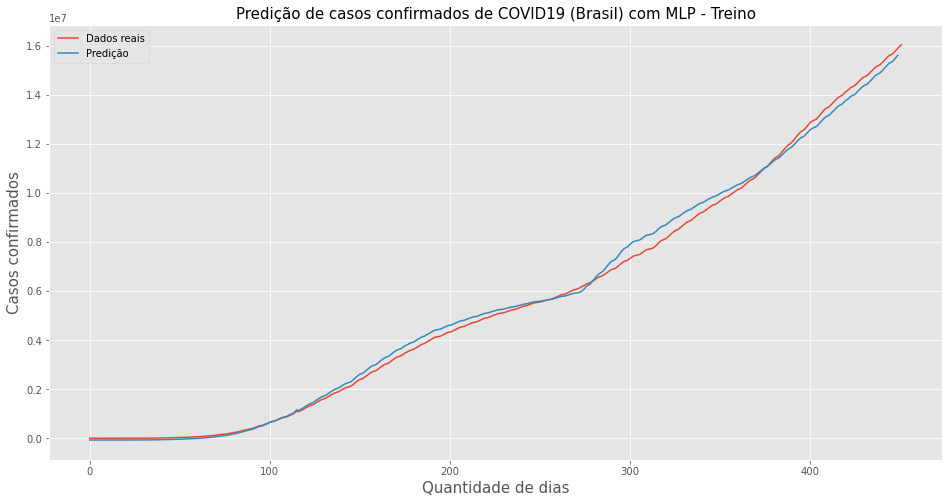

Train Score: 249147.24 RMSE
Taxa de aprendizagem: 0.1
Dropout: 0.05
Número de células por camada: 8

 MLP - O segundo melhor - Brasil 



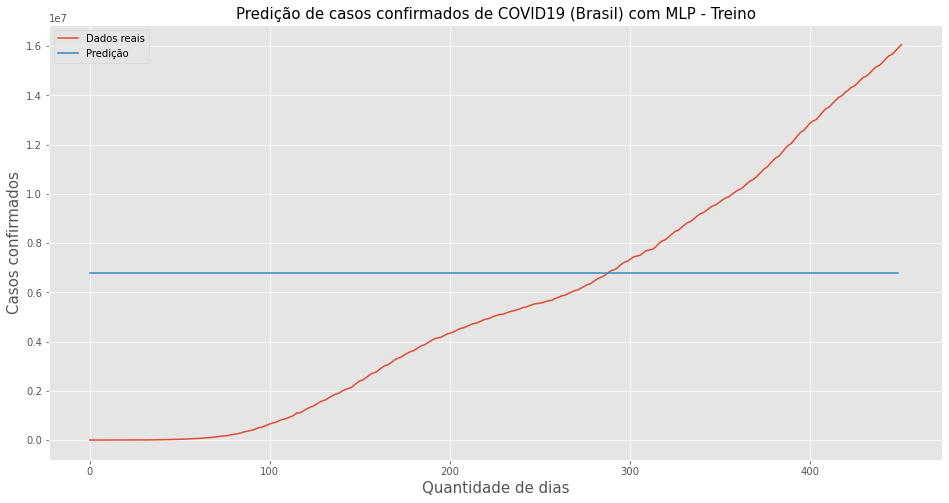

Train Score: 4891258.25 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células por camada: 8




 MLP - O melhor caso - Índia 



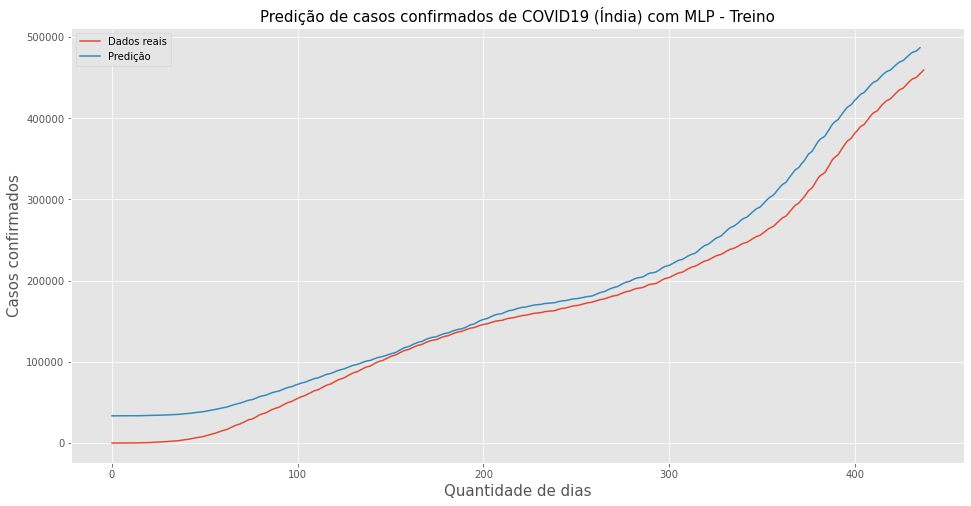

Train Score: 23613.28 RMSE
Taxa de aprendizagem: 0.05
Dropout: 0.1
Número de células por camada: 16

 MLP - O segundo melhor - Índia 



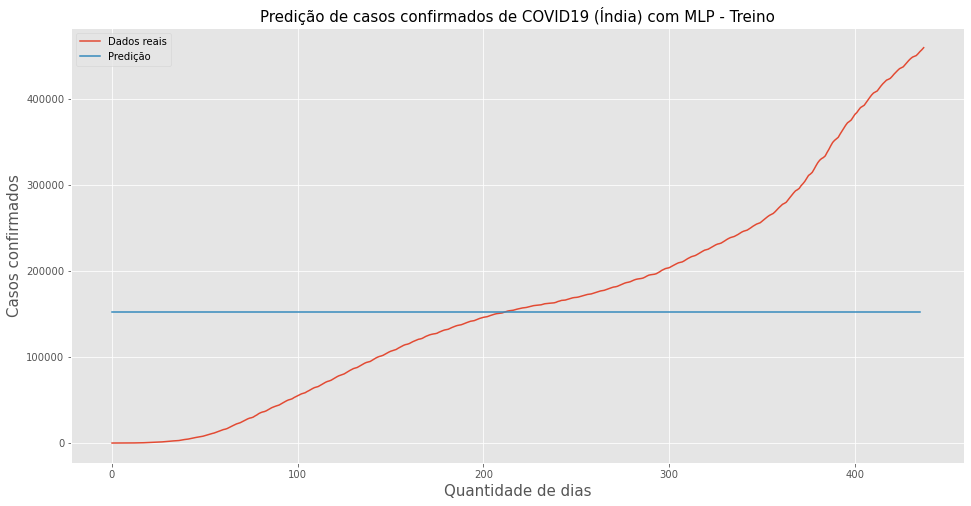

Train Score: 122958.07 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
Número de células por camada: 16





In [5]:
#Plotar gráficos com treinos do modelo MLP
for i in range(len(country)):
    print('\n MLP - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP - Treino' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)

    plt.plot(trainP[country[i]], label = 'Dados reais')
    plt.plot(strainPredMLP[country[i]], label = 'Predição')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (strsMLP[country[i]]))
    print('Taxa de aprendizagem:', st_aMLP[country[i]])
    print('Dropout:', sdropoutMLP[country[i]])
    print('Número de células por camada:',sn_neu[country[i]])


    print('\n MLP - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP - Treino' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(trainP[country[i]], label = 'Dados reais')
    plt.plot(trainPredMLP[country[i]], label = 'Predição')
    plt.legend()
    plt.show()
    print('Train Score: %.2f RMSE' % (trsMLP[country[i]]))
    print('Taxa de aprendizagem:', t_aMLP[country[i]])
    print('Dropout:', dropoutMLP[country[i]])

    print('Número de células por camada:',n_neu[country[i]])
 
    print('\n\n')


 MLP - O melhor caso - Brasil 



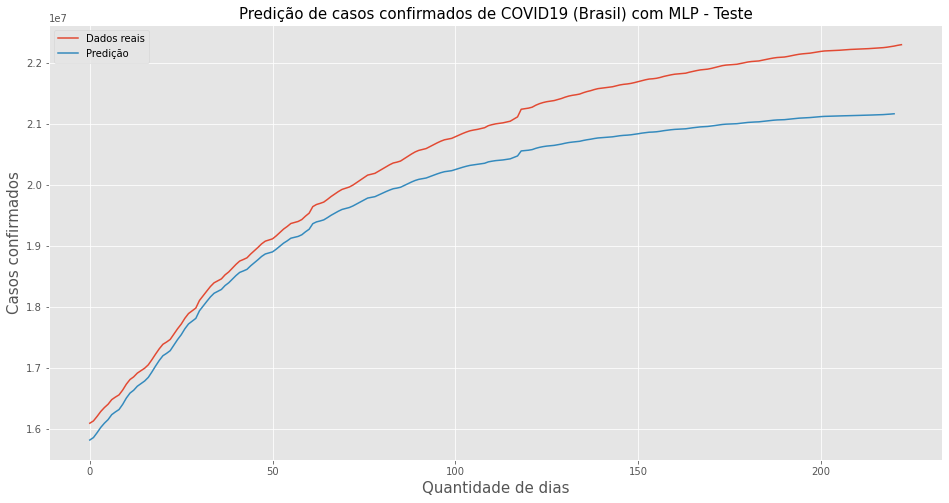

Test Score: 708290.07 RMSE
MAE: 636728.6336363255
Taxa de aprendizagem: 0.1
Dropout: 0.05
Número de células por camada: 8

 MLP - O segundo melhor - Brasil 



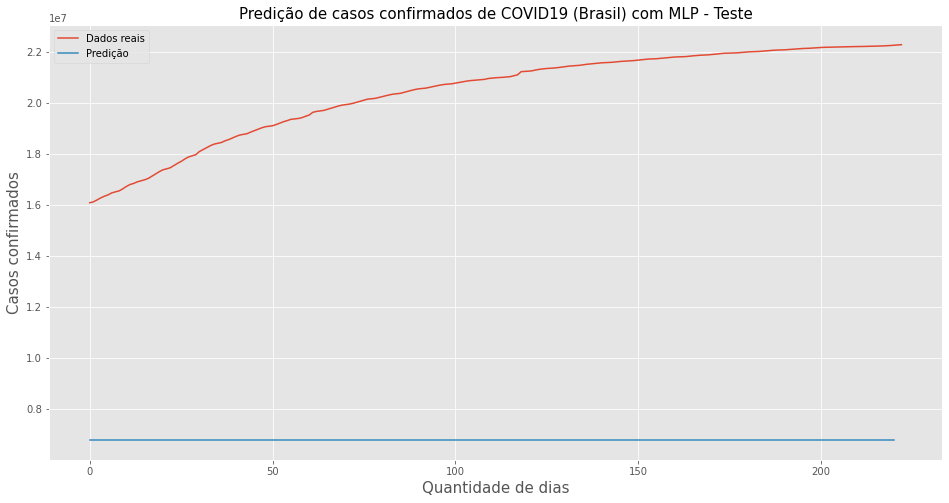

Test Score: 13767532.48 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 13659889.522776594
Número de células por camada: 8




 MLP - O melhor caso - Índia 



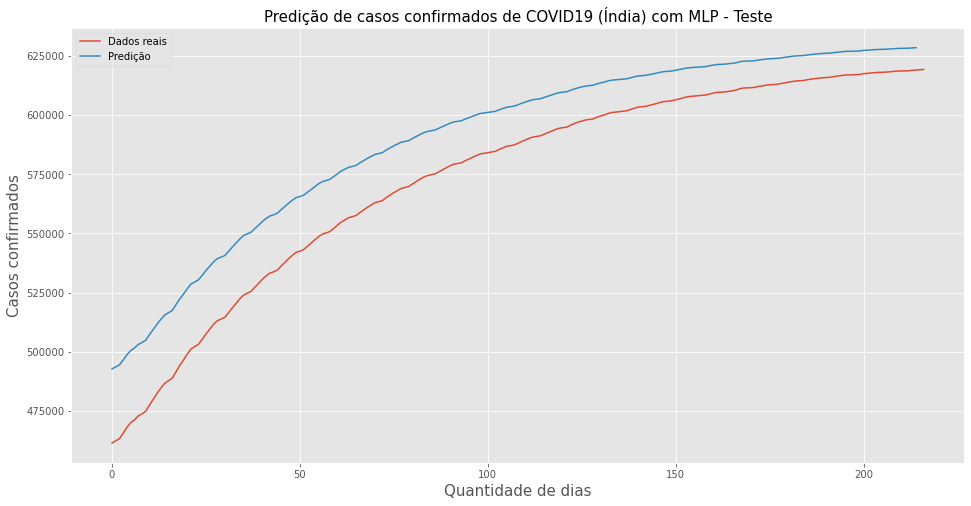

Test Score: 17867.96 RMSE
MAE: 16868.411448483832
Taxa de aprendizagem: 0.05
Dropout: 0.1
Número de células por camada: 16

 MLP - O segundo melhor - Índia 



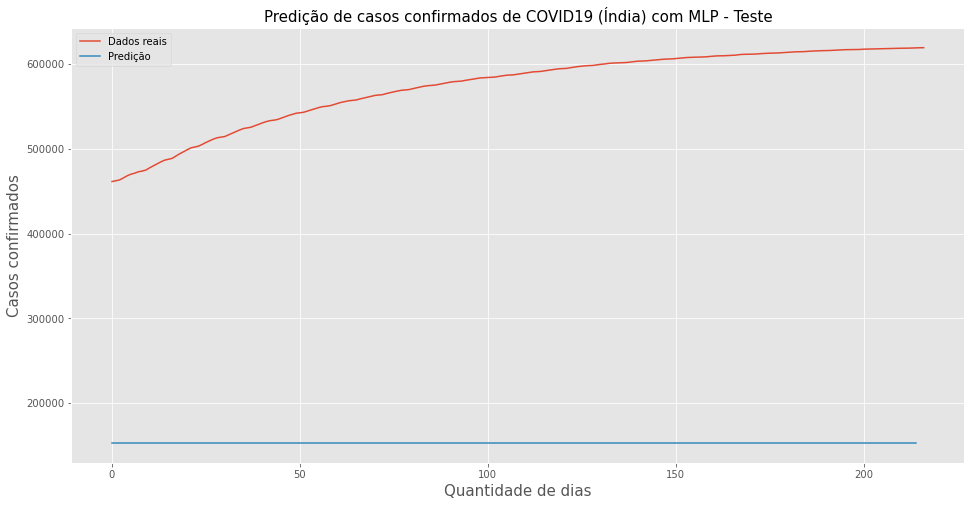

Test Score: 423150.16 RMSE
Taxa de aprendizagem: 0.2
Dropout: 0.2
MAE: 420908.4724177952
Número de células por camada: 16





In [6]:
#Plotar gráficos com testes do modelo MLP
for i in range(len(country)):
    print('\n MLP - O melhor caso - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP - Teste' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(testP[country[i]], label = 'Dados reais')
    plt.plot(stestPredMLP[country[i]], label = 'Predição')
    plt.legend()
    plt.show()

    print('Test Score: %.2f RMSE' % (stssMLP[country[i]]))
    print('MAE:', stsmMLP[country[i]])
    print('Taxa de aprendizagem:', st_aMLP[country[i]])
    print('Dropout:', sdropoutMLP[country[i]])
    print('Número de células por camada:',sn_neu[country[i]])


    print('\n MLP - O segundo melhor - %s \n' %(country[i]))
    plt.figure(figsize=(16,8))
    plt.title('Predição de casos confirmados de COVID19 (%s) com MLP - Teste' %(country[i]), size = 15)
    plt.ylabel('Casos confirmados', size = 15)
    plt.xlabel('Quantidade de dias', size = 15)
    plt.plot(testP[country[i]], label = 'Dados reais')
    plt.plot(testPredMLP[country[i]], label = 'Predição')
    plt.legend()
    plt.show()

    print('Test Score: %.2f RMSE' % (tssMLP[country[i]]))
    print('Taxa de aprendizagem:', t_aMLP[country[i]])
    print('Dropout:', dropoutMLP[country[i]])
    print('MAE:', tsmMLP[country[i]])
    print('Número de células por camada:',n_neu[country[i]])
 
    print('\n\n')